In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns
import tensorflow

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Input, Conv2D, LSTM, GRU, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
from numpy.random import seed
seed(13)
tensorflow.random.set_seed(2)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive')
current_path = os.path.join(os.getcwd(), 'gdrive/MyDrive')
dataset_path = os.path.join(current_path,"speech_commands_v0_02_dataset")
path_save_downsampled = os.path.join(current_path, "speech_commands_data/downsampled_dataset")

path_save_downsampled_logmelspectrogram = os.path.join(path_save_downsampled, 'log_mel_spectrogram')

path_save_augmented = os.path.join(path_save_downsampled, 'Augmented dataset')


Mounted at /content/gdrive


In [ ]:
os.listdir(path_save_augmented)

['x_train_augmented.npy',
 'label_train_augmented.npy',
 'x_train_augmented_logmelspectrogram_0.npy']

In [ ]:
def load_object(path_to_file):
  with open(path_to_file, "rb") as input_file:
    object = pickle.load(input_file)
  return object

def save_with_pickle(name_file, data, path_to_safe):
  with open(os.path.join(path_to_safe, name_file), "wb") as file:
      pickle.dump(data, file)

# Creation of classes

In [ ]:
augmented_train_label = np.load(os.path.join(path_save_augmented, 'label_train_augmented.npy'))
downsampled_val_label = load_object(os.path.join(path_save_downsampled, 'cleaned_label_val_downsampled.pickle'))
downsampled_test_label = load_object(os.path.join(path_save_downsampled, 'cleaned_label_test_downsampled.pickle'))

In [ ]:
commands_unkown_word = {"bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"}
commands = np.unique(augmented_train_label)

In [ ]:

def assign_num_to_command(commands, commands_unkown_word):
  """Assigns a number to each command. Commands belonging to commands_unkown_word
  will be assigned the same number (the last one).

  :param commands: List of all commands, including the ones that belong to
  command_unkown_word.
  :param commands_unkown_word: List of commands that belong to unknown word class.
  :return: Dictionary that maps each class with a number.
  """
  commands_numerical = {}

  c = 0
  for command in commands:
    if command not in commands_unkown_word:
      commands_numerical[str(command)] = c
      c += 1
    else:
      commands_numerical[str(command)] = len(commands) - len(commands_unkown_word)
  return(commands_numerical)

def create_label_numerical_array(labels):
  """Returns an array that has replaced the classes in "labels" by their
  assigned numbers.
  :param labels: List of labels (classes) of instances.
  :return: Array with the labels replaced by the corresponding number.
  """
  commands_numerical = assign_num_to_command(commands, commands_unkown_word)

  y_array = np.array(labels, dtype=object)
  for command in commands:
    y_array = np.where(y_array == command, commands_numerical[str(command)], y_array)
  return y_array


In [ ]:
label_train = create_label_numerical_array(augmented_train_label)

n_classes = len(set(label_train))

# One-hot encoding
y_train = to_categorical(label_train, num_classes=n_classes)
y_val = to_categorical(create_label_numerical_array(downsampled_val_label), num_classes=n_classes)
y_test = to_categorical(create_label_numerical_array(downsampled_test_label), num_classes=n_classes)


In [ ]:
classes = set(commands) - set(commands_unkown_word)
classes = np.unique(list(classes))
classes = np.append(classes, 'unkown_word')

# Load data

In [ ]:
augmented_train_data = np.load(os.path.join(path_save_augmented , 'x_train_augmented_logmelspectrogram_0.npy'))
downsampled_x_val_data = np.load(os.path.join(path_save_downsampled_logmelspectrogram , 'x_val_downsampled_logmelspectrogram_0.npy'))
downsampled_x_test_data = np.load(os.path.join(path_save_downsampled_logmelspectrogram , 'x_test_downsampled_logmelspectrogram_0.npy'))


In [ ]:
augmented_train_data.shape

(42465, 63, 64)

In [ ]:
# Normalize data
train_shape = np.array(augmented_train_data).shape

x_train_flattened = augmented_train_data.flatten()

scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train_flattened.reshape(-1, 1))

x_train = x_train_normalized.reshape(train_shape)

def normalize_data(data, scaler):
  shape = data.shape
  data_flattened = data.flatten()
  data_normalized = scaler.transform(data_flattened.reshape(-1,1))
  return data_normalized.reshape(shape)


In [ ]:
x_train.shape

(42465, 63, 64)

In [ ]:
x_val = normalize_data(downsampled_x_val_data, scaler)
x_test = normalize_data(downsampled_x_test_data, scaler)

In [ ]:

input_shape = (63, 64, 1)

In [ ]:
input_shape

(63, 64, 1)

# Functions for evaluating model

In [ ]:
class MetricsInfoShower:
  """Class for showing reports and graphics regarding training and test
  evaluation."""

  def __init__(self, model, h_model, x, y_true, batch_size, classes) -> None:
    self.model = model
    self.h_model = h_model
    self.last_epoch = len(self.h_model.history['loss'])
    self.batch_size = batch_size
    self.y_true = np.argmax(y_test, axis=1)
    self.y_pred = self._get_y_pred(x)
    self.classes = classes



  def _get_y_pred(self, x):
    y_pred = self.model.predict(x, batch_size=self.batch_size)
    return y_pred.argmax(axis=1)

  def show_classification_report(self):
    # Evaluación del modelo
    print("[INFO]: Evaluando el modelo...")

    # Report
    print(classification_report(self.y_true, self.y_pred, target_names=self.classes))

  def show_confusion_matrix(self):
    # Calcula la matriz de confusión
    cm = confusion_matrix(self.y_true, self.y_pred, normalize='pred')

    # Crea un gráfico de matriz de confusión utilizando seaborn
    plt.figure(figsize = (16, 16))
    ax = sns.heatmap(cm, annot=True, cmap="PuBu", fmt=".2f", xticklabels=self.classes, yticklabels=classes, vmin = 0.1 )

    # Añade etiquetas y título
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")

    plt.show()

  def show_training_loss(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  def show_training_accuracy(self):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, self.last_epoch), self.h_model.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

  def show_all(self):
    self.show_training_loss()
    self.show_training_accuracy()
    self.show_classification_report()
    self.show_confusion_matrix()

### Experimento_b1_gru_lme_0_00

In [ ]:
exp_b1_gru_lme_0_00 = Sequential([
    GRU(128, return_sequences=False, input_shape=(63, 64), activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_00.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x, verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_00.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_00.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_00 = exp_b1_gru_lme_0_00.fit(x_train, y_train, batch_size=batch_size, epochs=5, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4084 - loss: 1.9925
Epoch 1: val_loss improved from inf to 0.59655, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_00.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4086 - loss: 1.9919 - val_accuracy: 0.8270 - val_loss: 0.5965 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/5
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8452 - loss: 0.5025
Epoch 2: val_loss improved from 0.59655 to 0.48727, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_00.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8452 - loss: 0.5023 - val_accuracy: 0.8634 - val_loss: 0.4873 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/5
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8880 - loss: 0.3580
Epoch 3: val_loss improved from 0.48727 to 0.46292, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_00.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8881 - loss: 0.3578 - val_accuracy: 0.8685 - val_loss: 0.4629 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/5
1323/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9097 - loss: 0.2852
Epoch 4: val_loss improved from 0.46292 to 0.41481, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_00.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9098 - loss: 0.2851 - val_accuracy: 0.8829 - val_loss: 0.4148 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/5
1322/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9279 - loss: 0.2297
Epoch 5: val_loss did not improve from 0.41481
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9279 - loss: 0.2297 - val_accuracy: 0.8883 - val_loss: 0.4167 - learning_rate: 6.5610e-04


In [ ]:
exp_b1_gru_lme_0_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 128)                 │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,552 (912.32 KB)

 Trainable params: 77,850 (304.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 155,702 (608.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


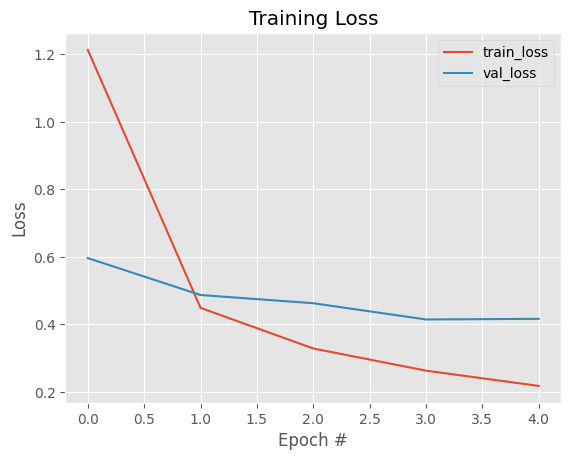

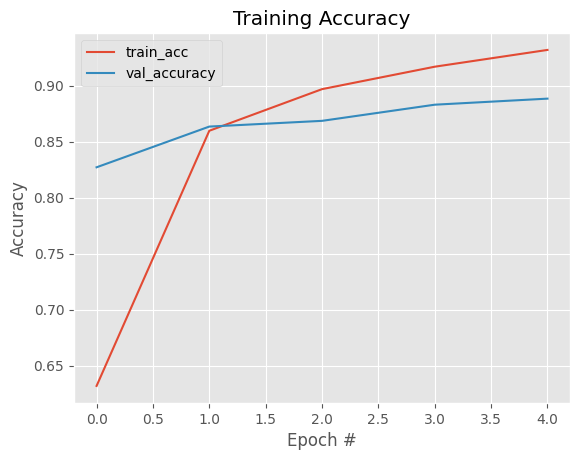

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.94      0.93       155
        down       0.89      0.81      0.85       155
       eight       0.98      0.85      0.91       155
        five       0.93      0.88      0.90       155
      follow       0.74      0.92      0.82       155
     forward       0.90      0.70      0.79       155
        four       0.80      0.79      0.80       155
          go       0.75      0.89      0.81       155
       learn       0.72      0.85      0.78       155
        left       0.90      0.94      0.92       155
        nine       0.88      0.90      0.89       155
          no       0.80      0.93      0.86       155
         off       0.97      0.85      0.91       155
          on       0.90      0.89      0.89       155
         one       0.91      0.89      0.90       155
       right       0.99      0.86      0.92       155
       seven       0.95      0.96      0.96       

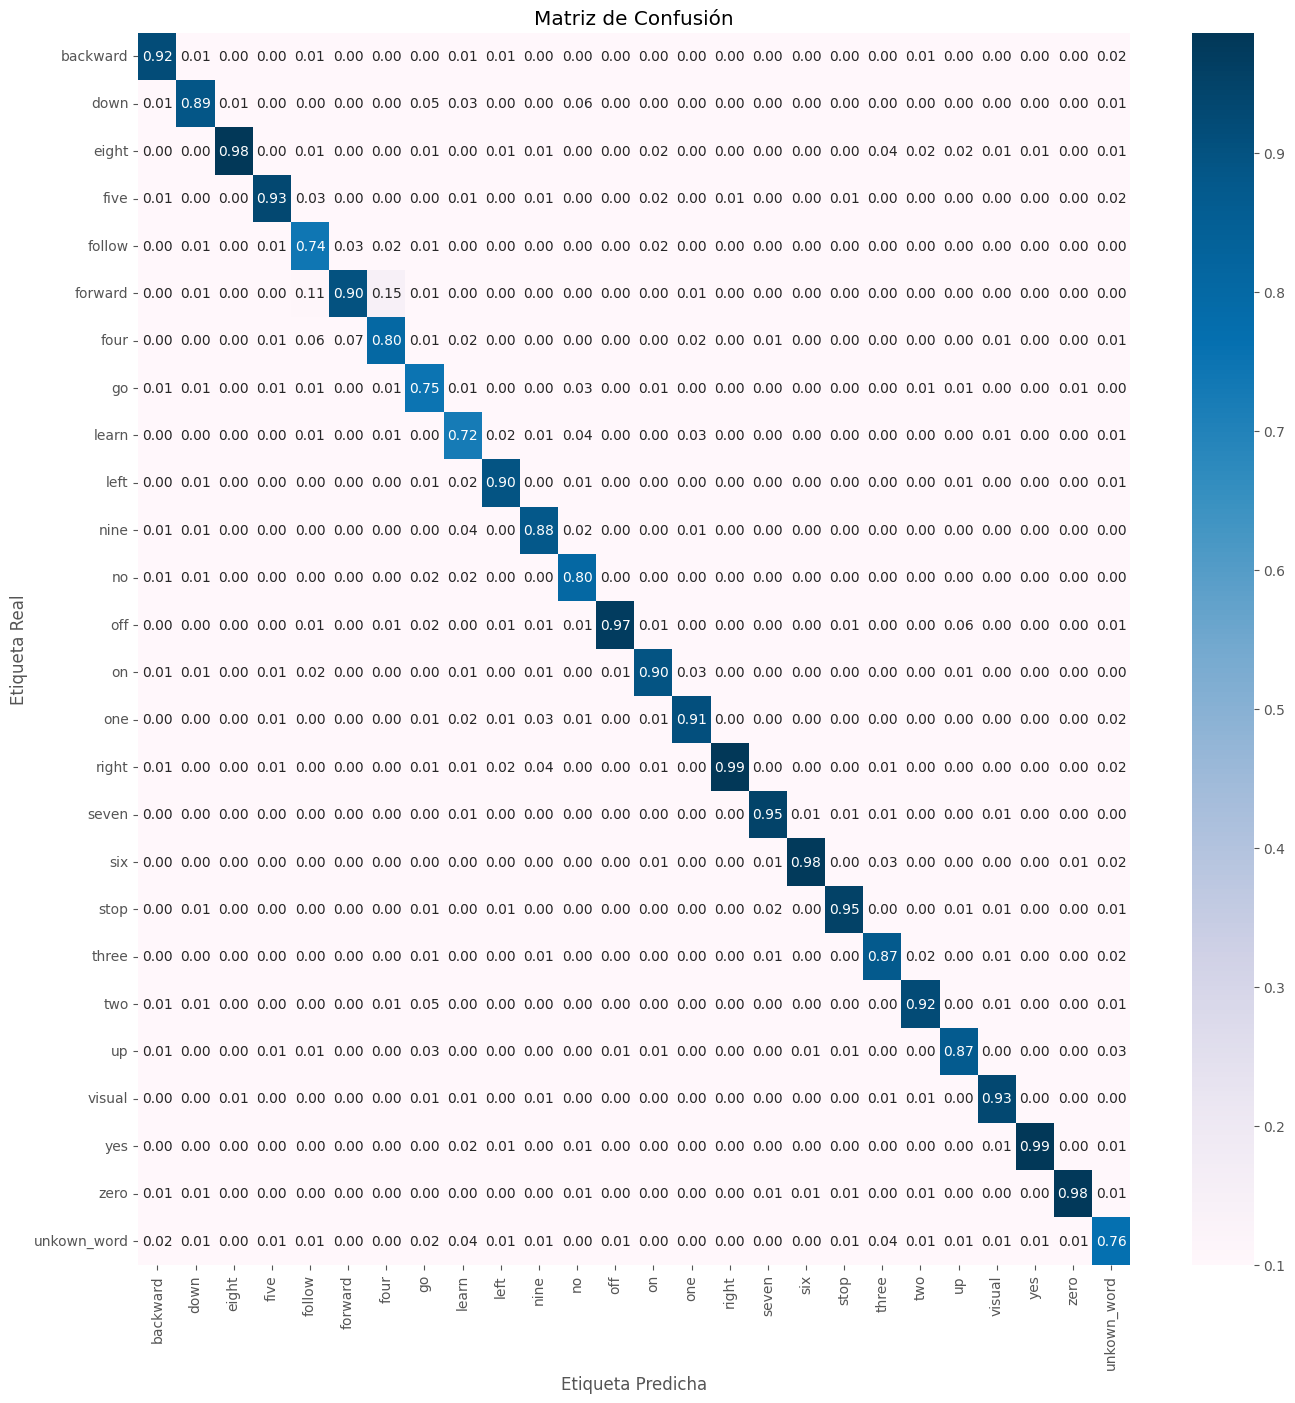

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_00, h_exp_b1_gru_lme_0_00, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_01

In [ ]:
exp_b1_gru_lme_0_01 = Sequential([
    GRU(64, return_sequences=False, input_shape=(63, 64), activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_01.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_01.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_01.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_01 = exp_b1_gru_lme_0_01.fit(x_train, y_train,
                                              batch_size=batch_size, epochs=90,
                                              validation_data=(x_val, y_val),
                                              callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3227 - loss: 2.2874
Epoch 1: val_loss improved from inf to 0.79858, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_01.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.3229 - loss: 2.2868 - val_accuracy: 0.7634 - val_loss: 0.7986 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8037 - loss: 0.6255
Epoch 2: val_loss improved from 0.79858 to 0.58719, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_01.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8038 - loss: 0.6254 - val_accuracy: 0.8231 - val_loss: 0.5872 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1323/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8521 - loss: 0.4734
Epoch 3: val_loss improved from 0.58719 to 0.52157, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_01.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8522 - loss: 0.4733 - val_accuracy: 0.8438 - val_loss: 0.5216 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1322/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8774 - loss: 0.3986
Epoch 4: val_loss improved from 0.52157 to 0.43990, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_01.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8774 - loss: 0.3985 - val_accuracy: 0.8730 - val_loss: 0.4399 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8924 - loss: 0.3494
Epoch 5: val_loss improved from 0.43990 to 0.42326, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_01.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8924 - loss: 0.3493 - val_accuracy: 0.8715 - val_loss: 0.4233 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9051 - loss: 0.3084
Epoch 6: val_loss improved from 0.42326 to 0.42112, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_01.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9052 - loss: 0.3084 - val_accuracy: 0.8763 - val_loss: 0.4211 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1323/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9137 - loss: 0.2787
Epoch 7: val_loss did not improve from 0.42112
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9137 - loss: 0.2787 - val_accuracy: 0.8784 - val_loss: 0.4321 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9206 - loss: 0.2550
Epoch 8: val_loss did not improve from 0.42112
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9206 - loss: 0.2550 - val_accuracy: 0.8799 - val_loss: 0.4266 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - 

In [ ]:
exp_b1_gru_lme_0_01.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,952 (312.32 KB)

 Trainable params: 26,650 (104.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,302 (208.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


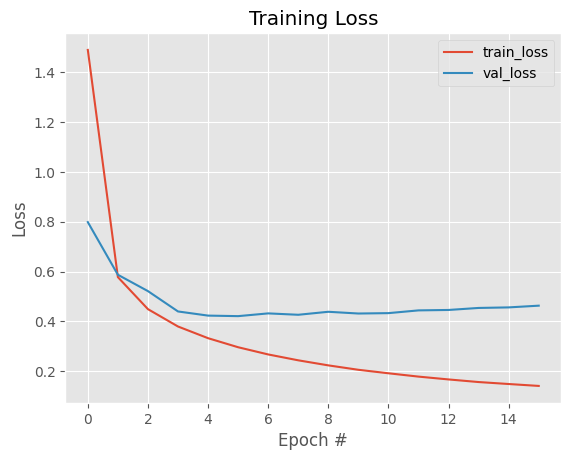

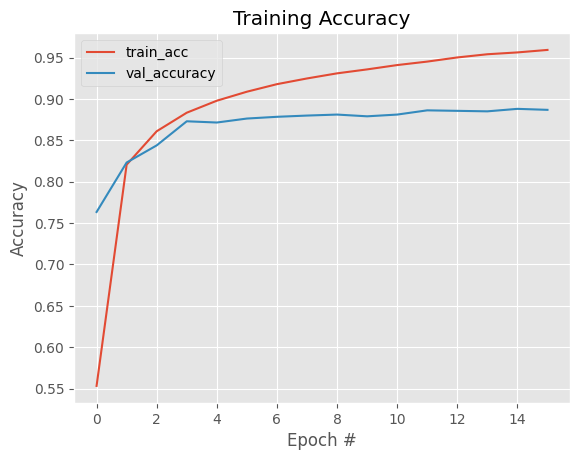

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.94      0.94      0.94       155
        down       0.90      0.79      0.84       155
       eight       0.95      0.90      0.92       155
        five       0.93      0.88      0.90       155
      follow       0.81      0.83      0.82       155
     forward       0.81      0.75      0.78       155
        four       0.80      0.79      0.79       155
          go       0.82      0.90      0.86       155
       learn       0.80      0.83      0.81       155
        left       0.91      0.90      0.91       155
        nine       0.92      0.91      0.91       155
          no       0.84      0.83      0.83       155
         off       0.98      0.87      0.92       155
          on       0.92      0.87      0.89       155
         one       0.92      0.90      0.91       155
       right       0.88      0.92      0.90       155
       seven       0.90      0.95      0.93       

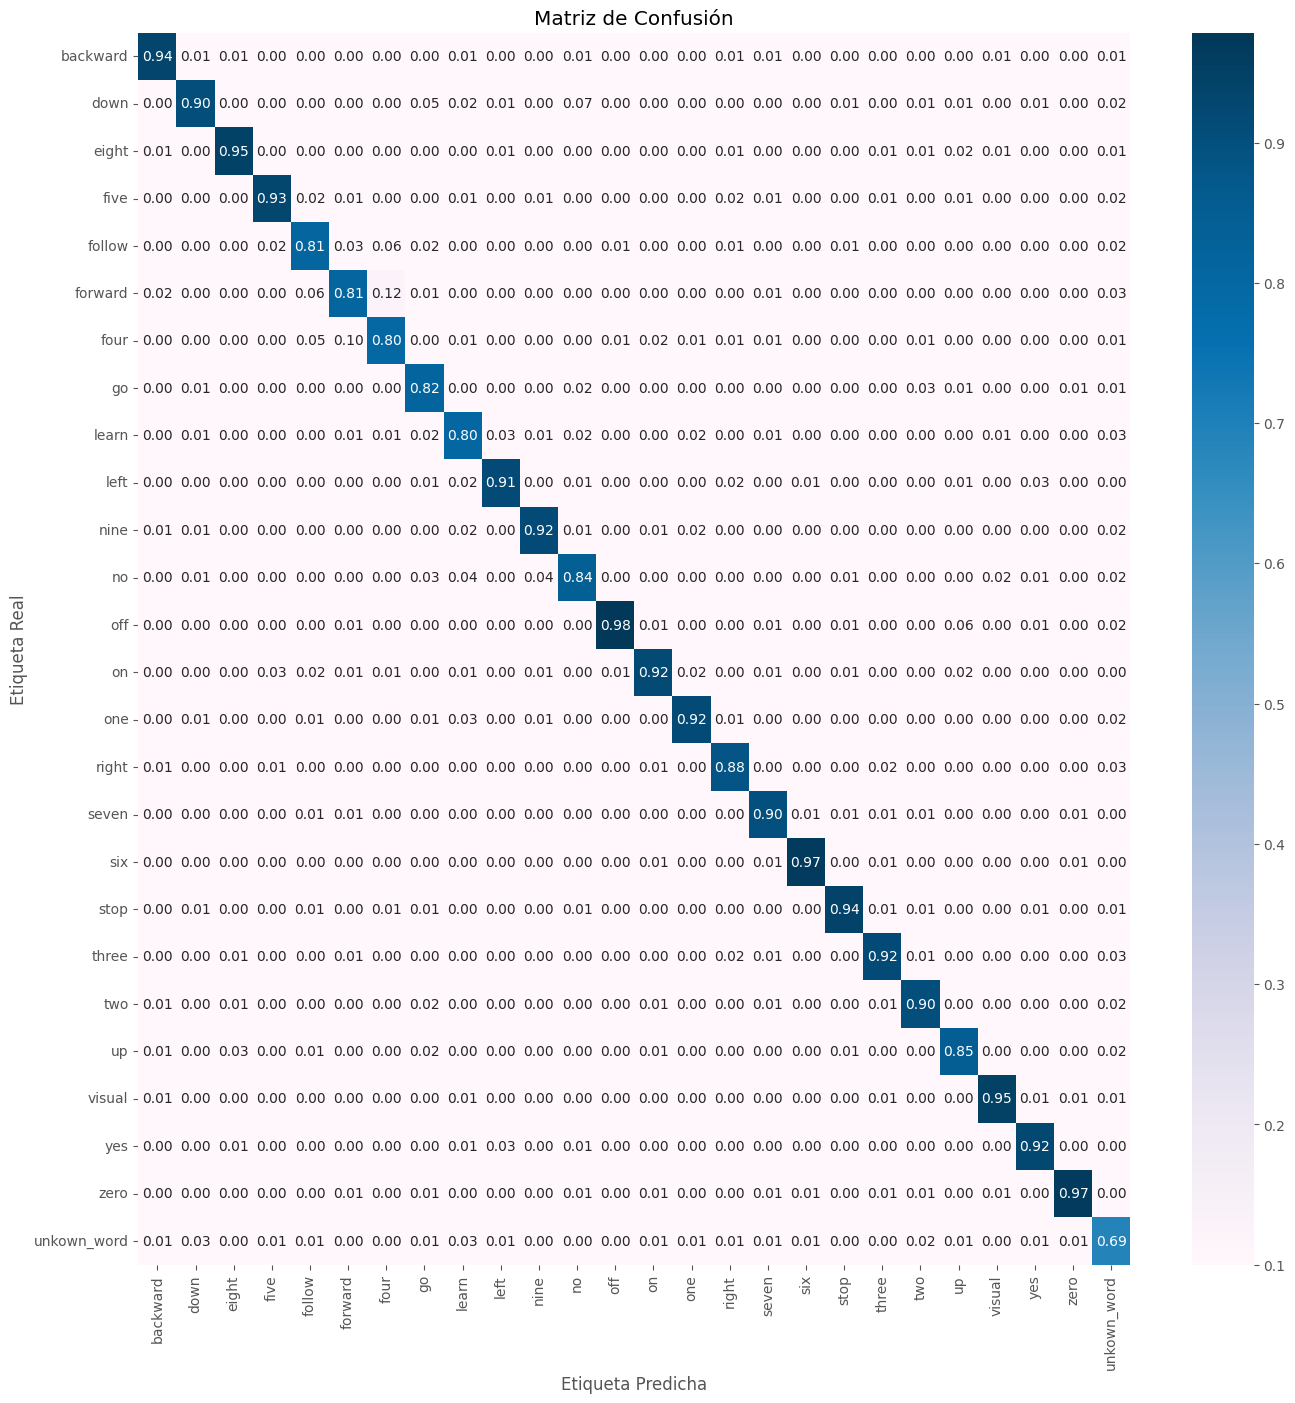

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_01, h_exp_b1_gru_lme_0_01, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_02

In [ ]:
exp_b1_gru_lme_0_02 = Sequential([
    GRU(32, return_sequences=False, input_shape=(63, 64), activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_02.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_02.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_02.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_02 = exp_b1_gru_lme_0_02.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2344 - loss: 2.6021
Epoch 1: val_loss improved from inf to 1.01722, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2346 - loss: 2.6016 - val_accuracy: 0.6952 - val_loss: 1.0172 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7370 - loss: 0.8674
Epoch 2: val_loss improved from 1.01722 to 0.81882, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7370 - loss: 0.8674 - val_accuracy: 0.7538 - val_loss: 0.8188 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7900 - loss: 0.6801
Epoch 3: val_loss improved from 0.81882 to 0.73583, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7901 - loss: 0.6800 - val_accuracy: 0.7781 - val_loss: 0.7358 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8207 - loss: 0.5909
Epoch 4: val_loss improved from 0.73583 to 0.65993, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8207 - loss: 0.5909 - val_accuracy: 0.8027 - val_loss: 0.6599 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8375 - loss: 0.5353
Epoch 5: val_loss improved from 0.65993 to 0.61469, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8375 - loss: 0.5353 - val_accuracy: 0.8189 - val_loss: 0.6147 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8505 - loss: 0.4950
Epoch 6: val_loss improved from 0.61469 to 0.58246, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8505 - loss: 0.4950 - val_accuracy: 0.8303 - val_loss: 0.5825 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8605 - loss: 0.4645
Epoch 7: val_loss improved from 0.58246 to 0.55580, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8605 - loss: 0.4644 - val_accuracy: 0.8402 - val_loss: 0.5558 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1323/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8683 - loss: 0.4402
Epoch 8: val_loss improved from 0.55580 to 0.54470, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8683 - loss: 0.4401 - val_accuracy: 0.8408 - val_loss: 0.5447 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1324/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8763 - loss: 0.4204
Epoch 9: val_loss improved from 0.54470 to 0.53944, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8763 - loss: 0.4204 - val_accuracy: 0.8450 - val_loss: 0.5394 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8810 - loss: 0.4032
Epoch 10: val_loss improved from 0.53944 to 0.53532, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8810 - loss: 0.4031 - val_accuracy: 0.8459 - val_loss: 0.5353 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8855 - loss: 0.3884
Epoch 11: val_loss improved from 0.53532 to 0.53047, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8855 - loss: 0.3884 - val_accuracy: 0.8495 - val_loss: 0.5305 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1324/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8901 - loss: 0.3761
Epoch 12: val_loss improved from 0.53047 to 0.52502, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8901 - loss: 0.3761 - val_accuracy: 0.8553 - val_loss: 0.5250 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8931 - loss: 0.3649
Epoch 13: val_loss improved from 0.52502 to 0.52008, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8931 - loss: 0.3649 - val_accuracy: 0.8559 - val_loss: 0.5201 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1324/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8957 - loss: 0.3557
Epoch 14: val_loss improved from 0.52008 to 0.51411, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8957 - loss: 0.3557 - val_accuracy: 0.8565 - val_loss: 0.5141 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8977 - loss: 0.3472
Epoch 15: val_loss improved from 0.51411 to 0.50932, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8977 - loss: 0.3472 - val_accuracy: 0.8571 - val_loss: 0.5093 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1320/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8995 - loss: 0.3398
Epoch 16: val_loss improved from 0.50932 to 0.50477, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8995 - loss: 0.3398 - val_accuracy: 0.8580 - val_loss: 0.5048 - learning_rate: 2.0589e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.00018530201888518417.
Epoch 17/90
1323/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9004 - loss: 0.3333
Epoch 17: val_loss improved from 0.50477 to 0.50177, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9004 - loss: 0.3332 - val_accuracy: 0.8583 - val_loss: 0.5018 - learning_rate: 1.8530e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.00016677181699666576.
Epoch 18/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9027 - loss: 0.3275
Epoch 18: val_loss improved from 0.50177 to 0.49846, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9027 - loss: 0.3275 - val_accuracy: 0.8592 - val_loss: 0.4985 - learning_rate: 1.6677e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.00015009463529699917.
Epoch 19/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9046 - loss: 0.3222
Epoch 19: val_loss improved from 0.49846 to 0.49601, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9046 - loss: 0.3222 - val_accuracy: 0.8604 - val_loss: 0.4960 - learning_rate: 1.5009e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0001350851717672993.
Epoch 20/90
1322/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9053 - loss: 0.3175
Epoch 20: val_loss improved from 0.49601 to 0.49350, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9053 - loss: 0.3175 - val_accuracy: 0.8613 - val_loss: 0.4935 - learning_rate: 1.3509e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.00012157665459056935.
Epoch 21/90
1322/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9064 - loss: 0.3132
Epoch 21: val_loss improved from 0.49350 to 0.49155, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9064 - loss: 0.3132 - val_accuracy: 0.8640 - val_loss: 0.4916 - learning_rate: 1.2158e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.00010941898913151242.
Epoch 22/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9074 - loss: 0.3094
Epoch 22: val_loss improved from 0.49155 to 0.48973, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9074 - loss: 0.3094 - val_accuracy: 0.8652 - val_loss: 0.4897 - learning_rate: 1.0942e-04

Epoch 23: LearningRateScheduler setting learning rate to 9.847709021836118e-05.
Epoch 23/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9083 - loss: 0.3059
Epoch 23: val_loss improved from 0.48973 to 0.48833, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9084 - loss: 0.3059 - val_accuracy: 0.8655 - val_loss: 0.4883 - learning_rate: 9.8477e-05

Epoch 24: LearningRateScheduler setting learning rate to 8.862938119652506e-05.
Epoch 24/90
1322/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9097 - loss: 0.3027
Epoch 24: val_loss improved from 0.48833 to 0.48689, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9097 - loss: 0.3027 - val_accuracy: 0.8652 - val_loss: 0.4869 - learning_rate: 8.8629e-05

Epoch 25: LearningRateScheduler setting learning rate to 7.976644307687256e-05.
Epoch 25/90
1324/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9106 - loss: 0.2998
Epoch 25: val_loss improved from 0.48689 to 0.48605, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9106 - loss: 0.2998 - val_accuracy: 0.8673 - val_loss: 0.4861 - learning_rate: 7.9766e-05

Epoch 26: LearningRateScheduler setting learning rate to 7.17897987691853e-05.
Epoch 26/90
1324/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9112 - loss: 0.2972
Epoch 26: val_loss improved from 0.48605 to 0.48538, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9112 - loss: 0.2972 - val_accuracy: 0.8685 - val_loss: 0.4854 - learning_rate: 7.1790e-05

Epoch 27: LearningRateScheduler setting learning rate to 6.461081889226677e-05.
Epoch 27/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9123 - loss: 0.2948
Epoch 27: val_loss improved from 0.48538 to 0.48499, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9123 - loss: 0.2948 - val_accuracy: 0.8685 - val_loss: 0.4850 - learning_rate: 6.4611e-05

Epoch 28: LearningRateScheduler setting learning rate to 5.8149737003040094e-05.
Epoch 28/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9126 - loss: 0.2928
Epoch 28: val_loss improved from 0.48499 to 0.48450, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9126 - loss: 0.2928 - val_accuracy: 0.8688 - val_loss: 0.4845 - learning_rate: 5.8150e-05

Epoch 29: LearningRateScheduler setting learning rate to 5.233476330273609e-05.
Epoch 29/90
1320/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9131 - loss: 0.2909
Epoch 29: val_loss improved from 0.48450 to 0.48442, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9131 - loss: 0.2909 - val_accuracy: 0.8691 - val_loss: 0.4844 - learning_rate: 5.2335e-05

Epoch 30: LearningRateScheduler setting learning rate to 4.7101286972462485e-05.
Epoch 30/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9135 - loss: 0.2892
Epoch 30: val_loss improved from 0.48442 to 0.48418, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9135 - loss: 0.2892 - val_accuracy: 0.8697 - val_loss: 0.4842 - learning_rate: 4.7101e-05

Epoch 31: LearningRateScheduler setting learning rate to 4.239115827521624e-05.
Epoch 31/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9135 - loss: 0.2877
Epoch 31: val_loss improved from 0.48418 to 0.48405, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9135 - loss: 0.2877 - val_accuracy: 0.8700 - val_loss: 0.4841 - learning_rate: 4.2391e-05

Epoch 32: LearningRateScheduler setting learning rate to 3.8152042447694614e-05.
Epoch 32/90
1321/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9137 - loss: 0.2863
Epoch 32: val_loss improved from 0.48405 to 0.48393, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9137 - loss: 0.2863 - val_accuracy: 0.8700 - val_loss: 0.4839 - learning_rate: 3.8152e-05

Epoch 33: LearningRateScheduler setting learning rate to 3.433683820292515e-05.
Epoch 33/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9144 - loss: 0.2850
Epoch 33: val_loss did not improve from 0.48393
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9144 - loss: 0.2850 - val_accuracy: 0.8715 - val_loss: 0.4839 - learning_rate: 3.4337e-05

Epoch 34: LearningRateScheduler setting learning rate to 3.090315438263264e-05.
Epoch 34/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9148 - loss: 0.2839
Epoch 34: val_loss improved from 0.48393 to 0.48387, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9148 - loss: 0.2839 - val_accuracy: 0.8709 - val_loss: 0.4839 - learning_rate: 3.0903e-05

Epoch 35: LearningRateScheduler setting learning rate to 2.7812838944369376e-05.
Epoch 35/90
1322/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9150 - loss: 0.2828
Epoch 35: val_loss did not improve from 0.48387
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9150 - loss: 0.2828 - val_accuracy: 0.8709 - val_loss: 0.4839 - learning_rate: 2.7813e-05

Epoch 36: LearningRateScheduler setting learning rate to 2.5031555049932436e-05.
Epoch 36/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9152 - loss: 0.2819
Epoch 36: val_loss improved from 0.48387 to 0.48381, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_02.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9152 - loss: 0.2819 - val_accuracy: 0.8709 - val_loss: 0.4838 - learning_rate: 2.5032e-05

Epoch 37: LearningRateScheduler setting learning rate to 2.2528399544939195e-05.
Epoch 37/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9155 - loss: 0.2810
Epoch 37: val_loss did not improve from 0.48381
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9155 - loss: 0.2810 - val_accuracy: 0.8706 - val_loss: 0.4839 - learning_rate: 2.2528e-05

Epoch 38: LearningRateScheduler setting learning rate to 2.0275559590445276e-05.
Epoch 38/90
1320/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9156 - loss: 0.2803
Epoch 38: val_loss did not improve from 0.48381
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9156 - loss: 0.2802 - val_accuracy: 0.8718 - val_loss: 0.4839 - learning_rate: 2.0276e-05

Epoch 39: LearningRateScheduler setting learning rate to 1.824800363140075e-05.
Epoch 39/90
1320/1328 ━━━━━━━━━━━━━━━

In [ ]:
exp_b1_gru_lme_0_02.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,800 (120.32 KB)

 Trainable params: 10,266 (40.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,534 (80.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


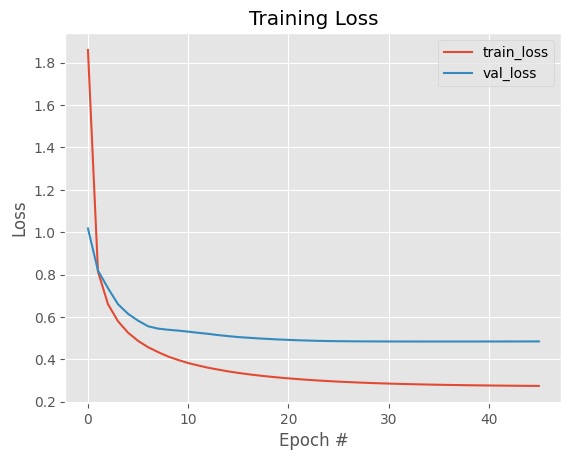

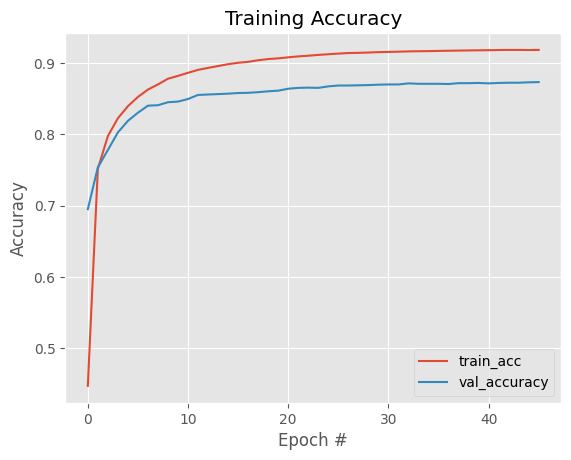

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.87      0.93      0.90       155
        down       0.89      0.74      0.81       155
       eight       0.95      0.89      0.92       155
        five       0.89      0.86      0.88       155
      follow       0.77      0.77      0.77       155
     forward       0.85      0.81      0.83       155
        four       0.80      0.79      0.80       155
          go       0.75      0.83      0.79       155
       learn       0.79      0.80      0.80       155
        left       0.88      0.88      0.88       155
        nine       0.90      0.92      0.91       155
          no       0.81      0.85      0.83       155
         off       0.91      0.90      0.91       155
          on       0.89      0.89      0.89       155
         one       0.91      0.88      0.90       155
       right       0.92      0.87      0.90       155
       seven       0.92      0.92      0.92       

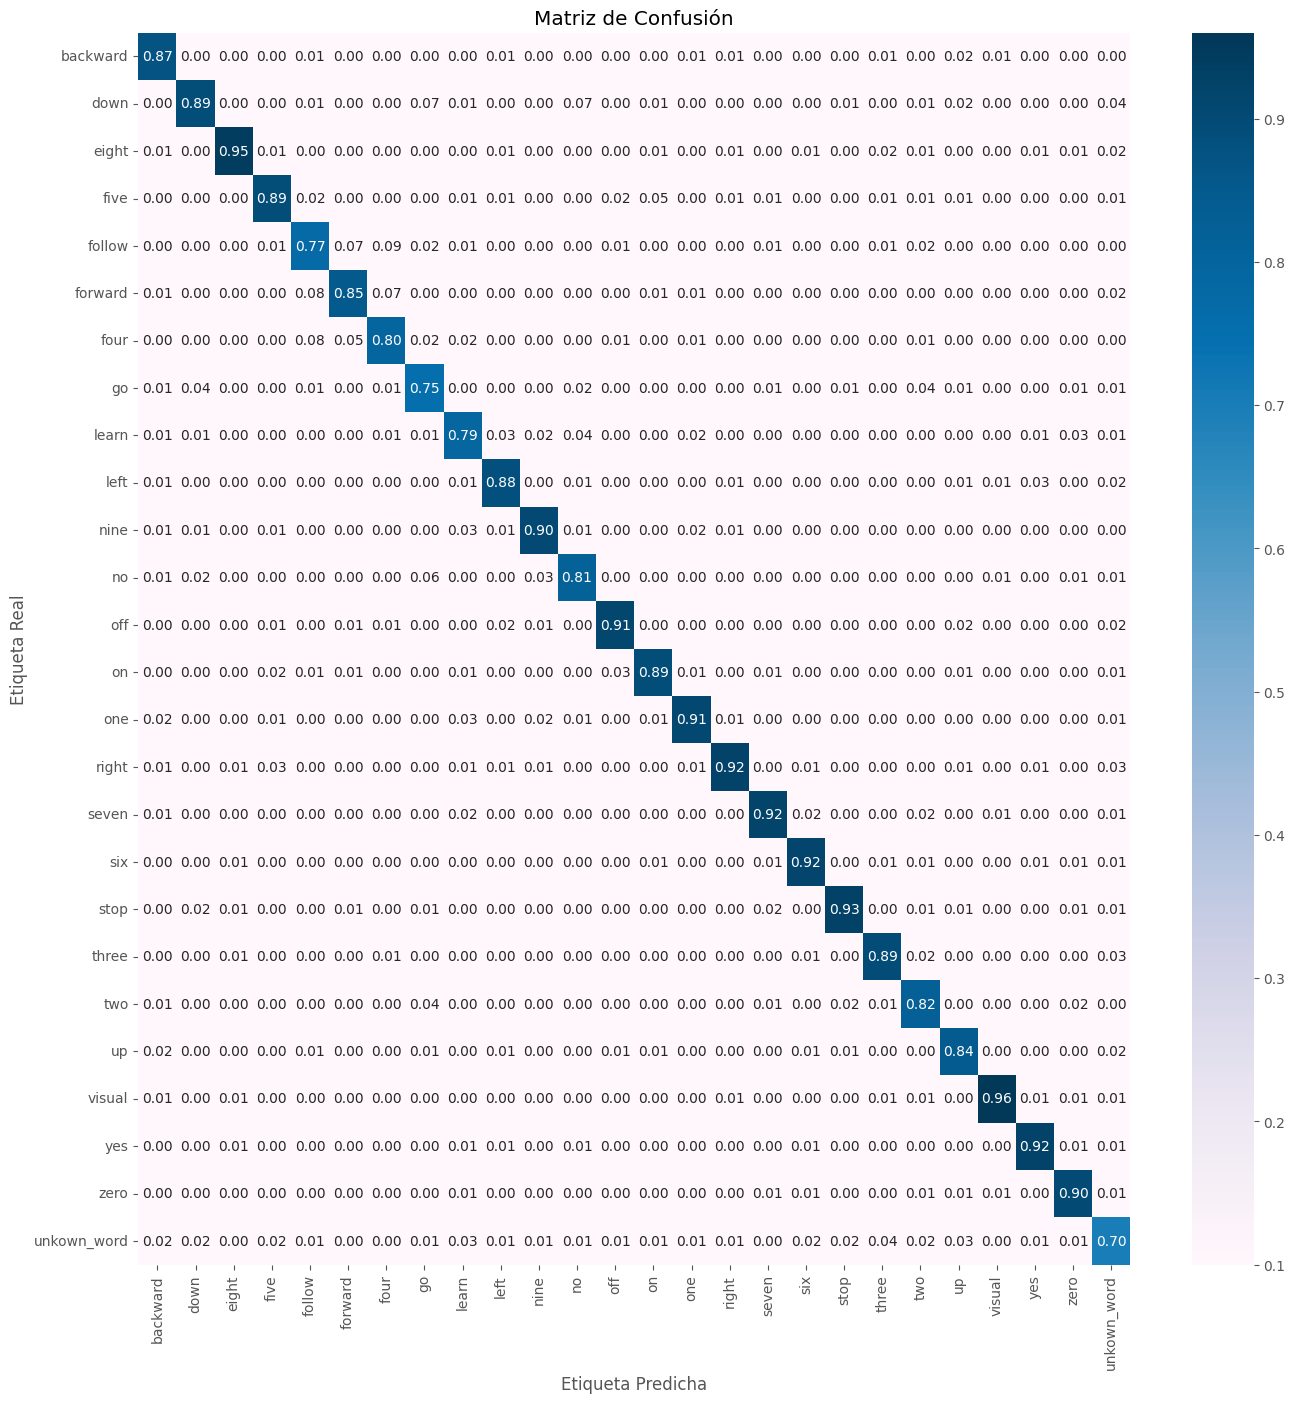

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_02, h_exp_b1_gru_lme_0_02, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_03

In [ ]:
exp_b1_gru_lme_0_03 = Sequential([
    GRU(64, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.2),
    GRU(64, return_sequences=False, activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_03.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_03.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_03.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_03 = exp_b1_gru_lme_0_03.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3795 - loss: 2.0901
Epoch 1: val_loss improved from inf to 0.71385, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.3796 - loss: 2.0895 - val_accuracy: 0.7880 - val_loss: 0.7139 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8163 - loss: 0.5862
Epoch 2: val_loss improved from 0.71385 to 0.49128, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8164 - loss: 0.5860 - val_accuracy: 0.8492 - val_loss: 0.4913 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8666 - loss: 0.4237
Epoch 3: val_loss improved from 0.49128 to 0.44900, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8666 - loss: 0.4236 - val_accuracy: 0.8685 - val_loss: 0.4490 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8908 - loss: 0.3504
Epoch 4: val_loss improved from 0.44900 to 0.42319, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8908 - loss: 0.3504 - val_accuracy: 0.8853 - val_loss: 0.4232 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9040 - loss: 0.3029
Epoch 5: val_loss improved from 0.42319 to 0.41225, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9040 - loss: 0.3028 - val_accuracy: 0.8880 - val_loss: 0.4122 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9130 - loss: 0.2679
Epoch 6: val_loss improved from 0.41225 to 0.39893, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9130 - loss: 0.2679 - val_accuracy: 0.8883 - val_loss: 0.3989 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1324/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9239 - loss: 0.2398
Epoch 7: val_loss improved from 0.39893 to 0.37869, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_03.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9239 - loss: 0.2397 - val_accuracy: 0.8946 - val_loss: 0.3787 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9320 - loss: 0.2153
Epoch 8: val_loss did not improve from 0.37869
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9320 - loss: 0.2153 - val_accuracy: 0.8913 - val_loss: 0.3832 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9362 - loss: 0.1985
Epoch 9: val_loss did not improve from 0.37869
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9362 - loss: 0.1985 - val_accuracy: 0.8910 - val_loss: 0.3858 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1326/1328 ━━━━━━━━━━━━━━━━━━

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9442 - loss: 0.1717 - val_accuracy: 0.8991 - val_loss: 0.3700 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9500 - loss: 0.1543
Epoch 12: val_loss did not improve from 0.37002
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9500 - loss: 0.1543 - val_accuracy: 0.8973 - val_loss: 0.3904 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9545 - loss: 0.1450
Epoch 13: val_loss did not improve from 0.37002
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9546 - loss: 0.1449 - val_accuracy: 0.8961 - val_loss: 0.3896 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1326/1328 ━━━━━━━━━━━━

In [ ]:
exp_b1_gru_lme_0_03.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                          │ (None, 63, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,832 (604.82 KB)

 Trainable params: 51,610 (201.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,222 (403.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


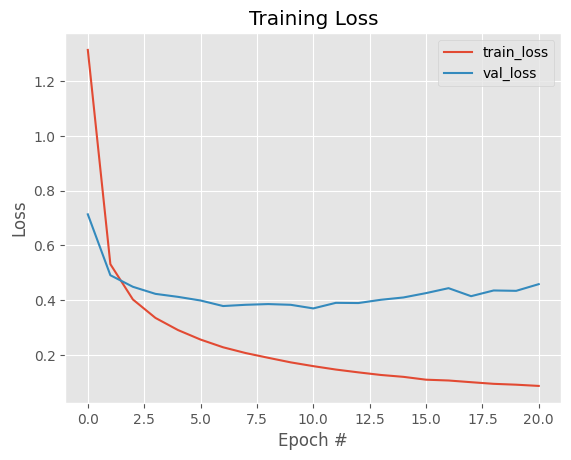

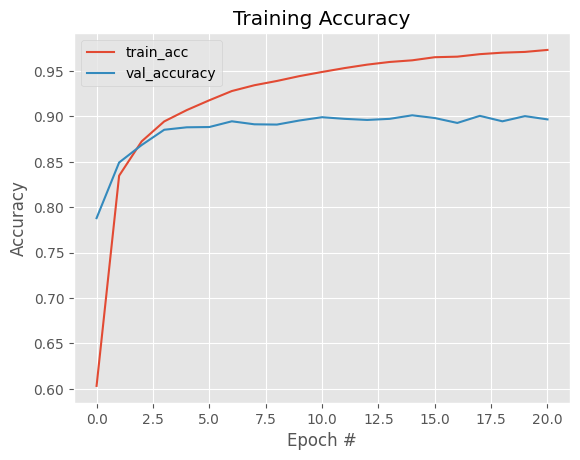

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.92      0.95      0.94       155
        down       0.89      0.86      0.87       155
       eight       0.94      0.90      0.92       155
        five       0.91      0.90      0.90       155
      follow       0.86      0.87      0.87       155
     forward       0.88      0.86      0.87       155
        four       0.83      0.82      0.82       155
          go       0.90      0.86      0.88       155
       learn       0.83      0.81      0.82       155
        left       0.92      0.87      0.89       155
        nine       0.96      0.96      0.96       155
          no       0.89      0.90      0.89       155
         off       0.95      0.91      0.93       155
          on       0.89      0.92      0.90       155
         one       0.89      0.92      0.91       155
       right       0.91      0.95      0.93       155
       seven       0.92      0.93      0.93       

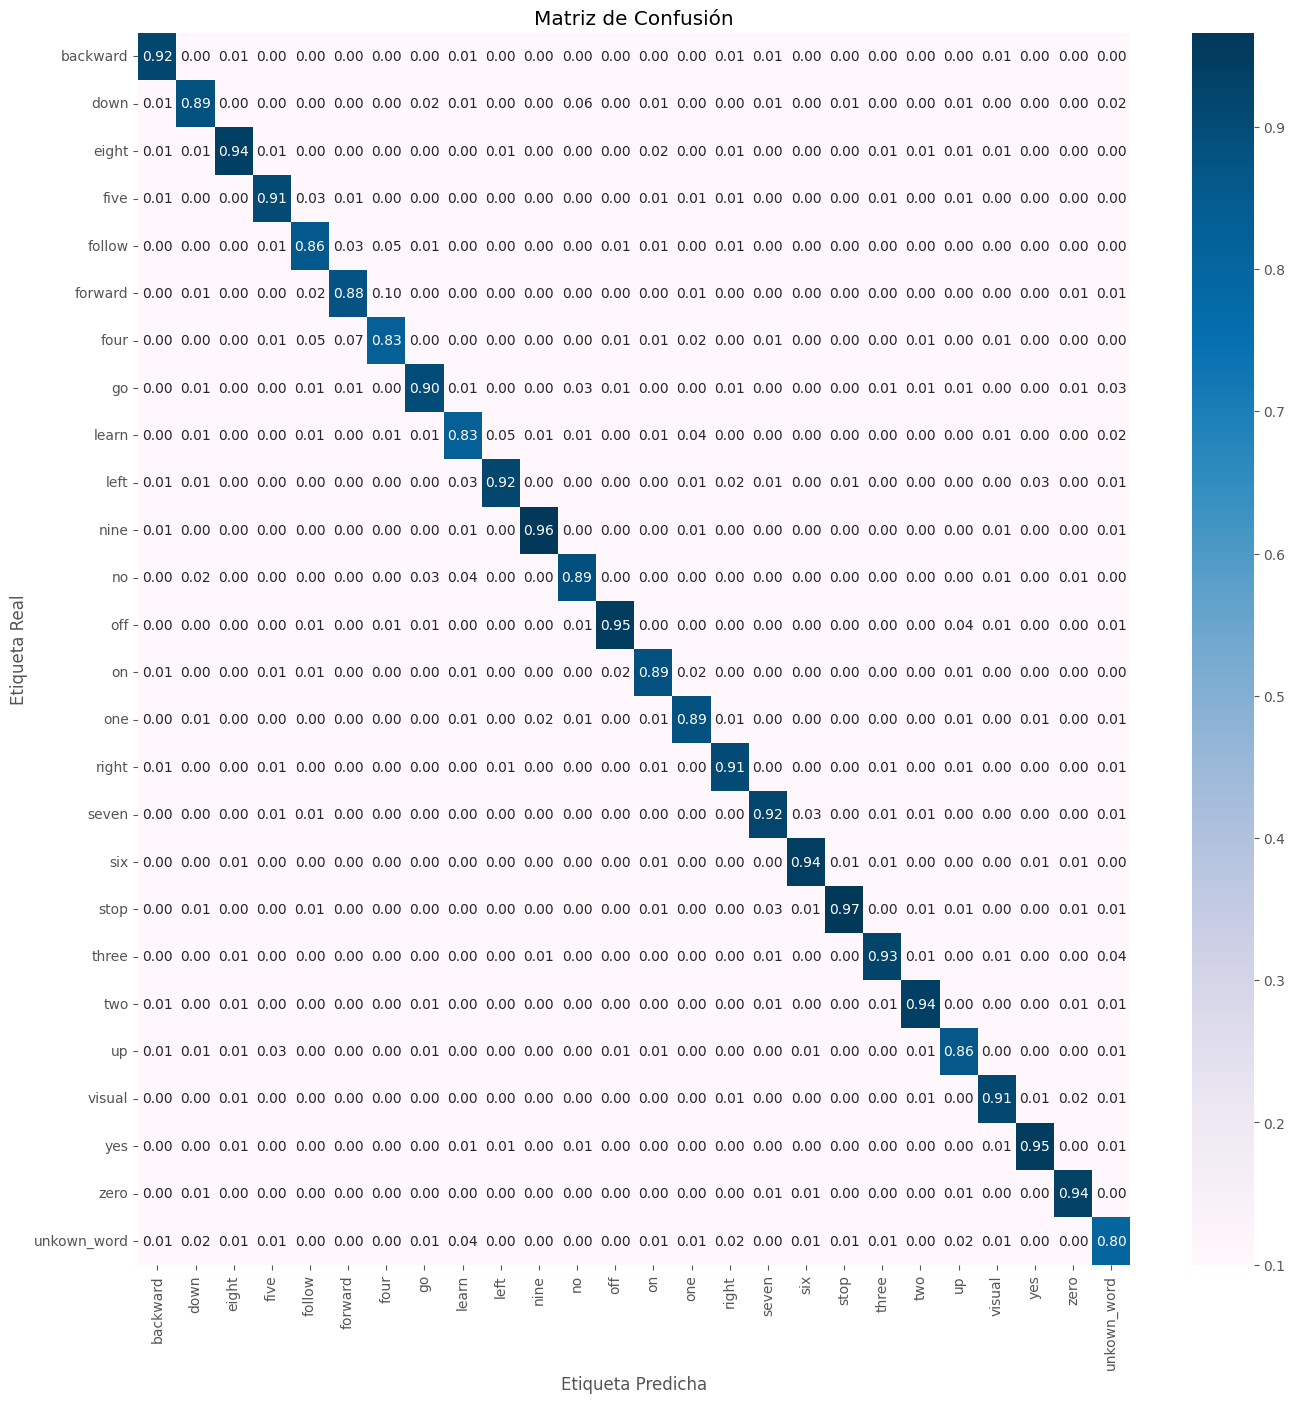

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_03, h_exp_b1_gru_lme_0_03, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_04

In [ ]:
exp_b1_gru_lme_0_04 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.2),
    GRU(128, return_sequences=False, activation='relu'),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_04.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_04.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_04.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_04 = exp_b1_gru_lme_0_04.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4420 - loss: 1.8644
Epoch 1: val_loss improved from inf to 0.52092, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_04.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.4422 - loss: 1.8638 - val_accuracy: 0.8492 - val_loss: 0.5209 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8581 - loss: 0.4562
Epoch 2: val_loss improved from 0.52092 to 0.38928, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_04.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.8581 - loss: 0.4562 - val_accuracy: 0.8850 - val_loss: 0.3893 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8976 - loss: 0.3200
Epoch 3: val_loss improved from 0.38928 to 0.36127, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_04.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8976 - loss: 0.3200 - val_accuracy: 0.8955 - val_loss: 0.3613 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9179 - loss: 0.2521
Epoch 4: val_loss improved from 0.36127 to 0.33728, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_04.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9179 - loss: 0.2520 - val_accuracy: 0.9021 - val_loss: 0.3373 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1325/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9302 - loss: 0.2123
Epoch 5: val_loss improved from 0.33728 to 0.33148, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_04.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9302 - loss: 0.2122 - val_accuracy: 0.9093 - val_loss: 0.3315 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9452 - loss: 0.1724
Epoch 6: val_loss improved from 0.33148 to 0.30089, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_04.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9452 - loss: 0.1724 - val_accuracy: 0.9171 - val_loss: 0.3009 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9532 - loss: 0.1464
Epoch 7: val_loss did not improve from 0.30089
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9532 - loss: 0.1463 - val_accuracy: 0.9150 - val_loss: 0.3234 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9600 - loss: 0.1250
Epoch 8: val_loss did not improve from 0.30089
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9600 - loss: 0.1250 - val_accuracy: 0.9195 - val_loss: 0.3058 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

In [ ]:
exp_b1_gru_lme_0_04.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 530,768 (2.02 MB)

 Trainable params: 176,922 (691.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 353,846 (1.35 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


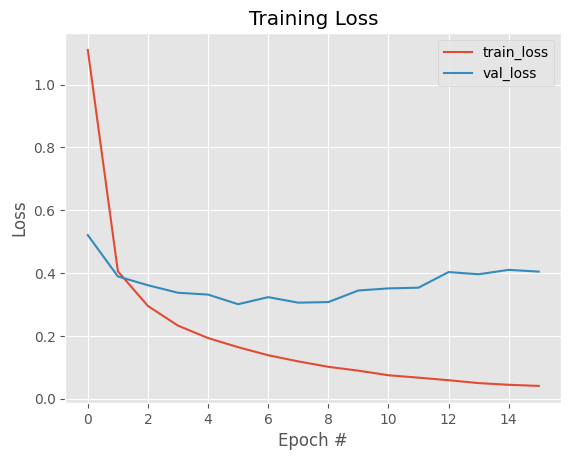

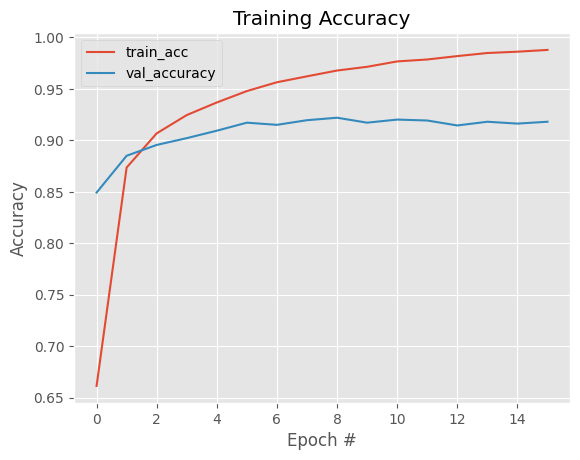

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.94      0.99      0.97       155
        down       0.93      0.90      0.92       155
       eight       0.95      0.90      0.92       155
        five       0.95      0.89      0.92       155
      follow       0.80      0.88      0.84       155
     forward       0.93      0.82      0.87       155
        four       0.83      0.86      0.85       155
          go       0.93      0.90      0.92       155
       learn       0.86      0.86      0.86       155
        left       0.90      0.95      0.93       155
        nine       0.91      0.96      0.94       155
          no       0.89      0.94      0.92       155
         off       0.95      0.93      0.94       155
          on       0.91      0.94      0.92       155
         one       0.94      0.92      0.93       155
       right       0.97      0.92      0.95       155
       seven       0.90      0.98      0.94       

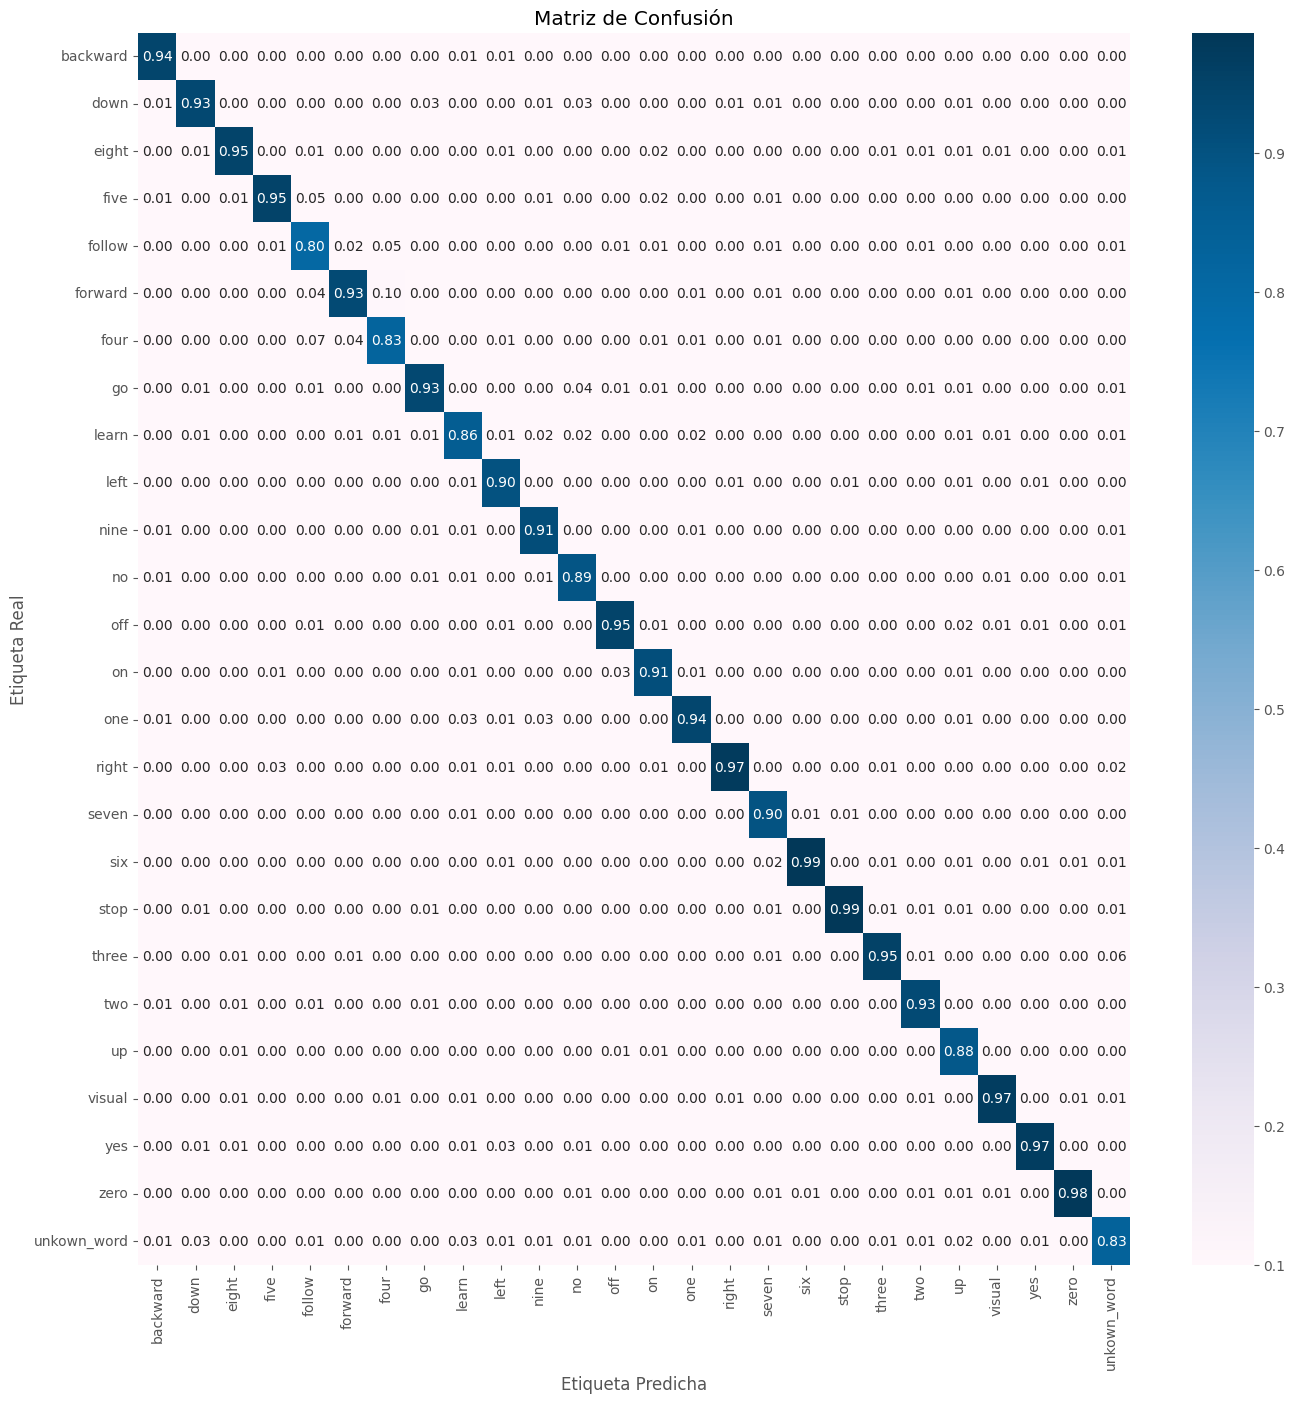

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_04, h_exp_b1_gru_lme_0_04, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_05

In [ ]:
exp_b1_gru_lme_0_05 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.4),
    GRU(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_05.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_05.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_05.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_05 = exp_b1_gru_lme_0_05.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2692 - loss: 2.4220
Epoch 1: val_loss improved from inf to 0.77797, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.2694 - loss: 2.4214 - val_accuracy: 0.7667 - val_loss: 0.7780 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7651 - loss: 0.7855
Epoch 2: val_loss improved from 0.77797 to 0.57865, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.7651 - loss: 0.7853 - val_accuracy: 0.8315 - val_loss: 0.5787 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8258 - loss: 0.5816
Epoch 3: val_loss improved from 0.57865 to 0.48584, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.8258 - loss: 0.5815 - val_accuracy: 0.8595 - val_loss: 0.4858 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8587 - loss: 0.4730
Epoch 4: val_loss improved from 0.48584 to 0.45466, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8587 - loss: 0.4730 - val_accuracy: 0.8736 - val_loss: 0.4547 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8803 - loss: 0.4004
Epoch 5: val_loss improved from 0.45466 to 0.42901, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8803 - loss: 0.4004 - val_accuracy: 0.8802 - val_loss: 0.4290 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8933 - loss: 0.3544
Epoch 6: val_loss improved from 0.42901 to 0.41011, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.8933 - loss: 0.3544 - val_accuracy: 0.8895 - val_loss: 0.4101 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9058 - loss: 0.3143
Epoch 7: val_loss did not improve from 0.41011
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9058 - loss: 0.3143 - val_accuracy: 0.8889 - val_loss: 0.4189 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9127 - loss: 0.2863
Epoch 8: val_loss did not improve from 0.41011
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.9127 - loss: 0.2863 - val_accuracy: 0.8850 - val_loss: 0.4120 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/s

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9205 - loss: 0.2591 - val_accuracy: 0.8952 - val_loss: 0.4006 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9288 - loss: 0.2338
Epoch 10: val_loss improved from 0.40061 to 0.38305, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9288 - loss: 0.2338 - val_accuracy: 0.8994 - val_loss: 0.3831 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9338 - loss: 0.2208
Epoch 11: val_loss improved from 0.38305 to 0.37734, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_05.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9338 - loss: 0.2208 - val_accuracy: 0.8988 - val_loss: 0.3773 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9399 - loss: 0.2034
Epoch 12: val_loss did not improve from 0.37734
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.9399 - loss: 0.2034 - val_accuracy: 0.8961 - val_loss: 0.4220 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9419 - loss: 0.1959
Epoch 13: val_loss did not improve from 0.37734
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - accuracy: 0.9419 - loss: 0.1959 - val_accuracy: 0.9036 - val_loss: 0.4141 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1327/1328 ━━━━━━━━━━━━

In [ ]:
exp_b1_gru_lme_0_05.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_7 (GRU)                          │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, 63, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_9 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 26)                  │             858 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,032 (1.40 MB)

 Trainable params: 122,010 (476.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,022 (953.21 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


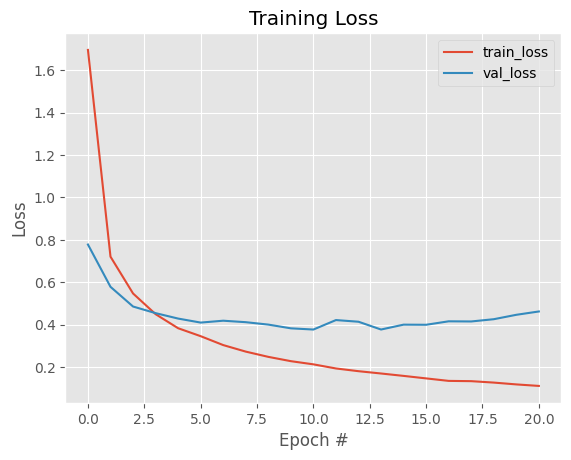

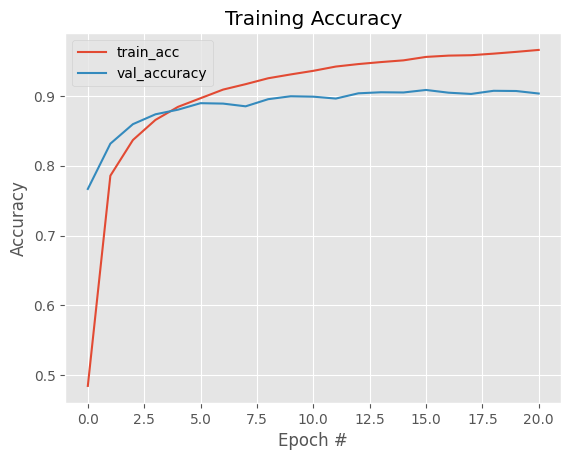

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.94      0.94      0.94       155
        down       0.95      0.81      0.87       155
       eight       0.90      0.95      0.93       155
        five       0.92      0.84      0.88       155
      follow       0.83      0.84      0.83       155
     forward       0.84      0.81      0.83       155
        four       0.79      0.83      0.81       155
          go       0.84      0.89      0.86       155
       learn       0.83      0.83      0.83       155
        left       0.95      0.90      0.92       155
        nine       0.95      0.89      0.92       155
          no       0.87      0.88      0.88       155
         off       0.92      0.94      0.93       155
          on       0.90      0.90      0.90       155
         one       0.95      0.90      0.92       155
       right       0.97      0.91      0.94       155
       seven       0.92      0.95      0.94       

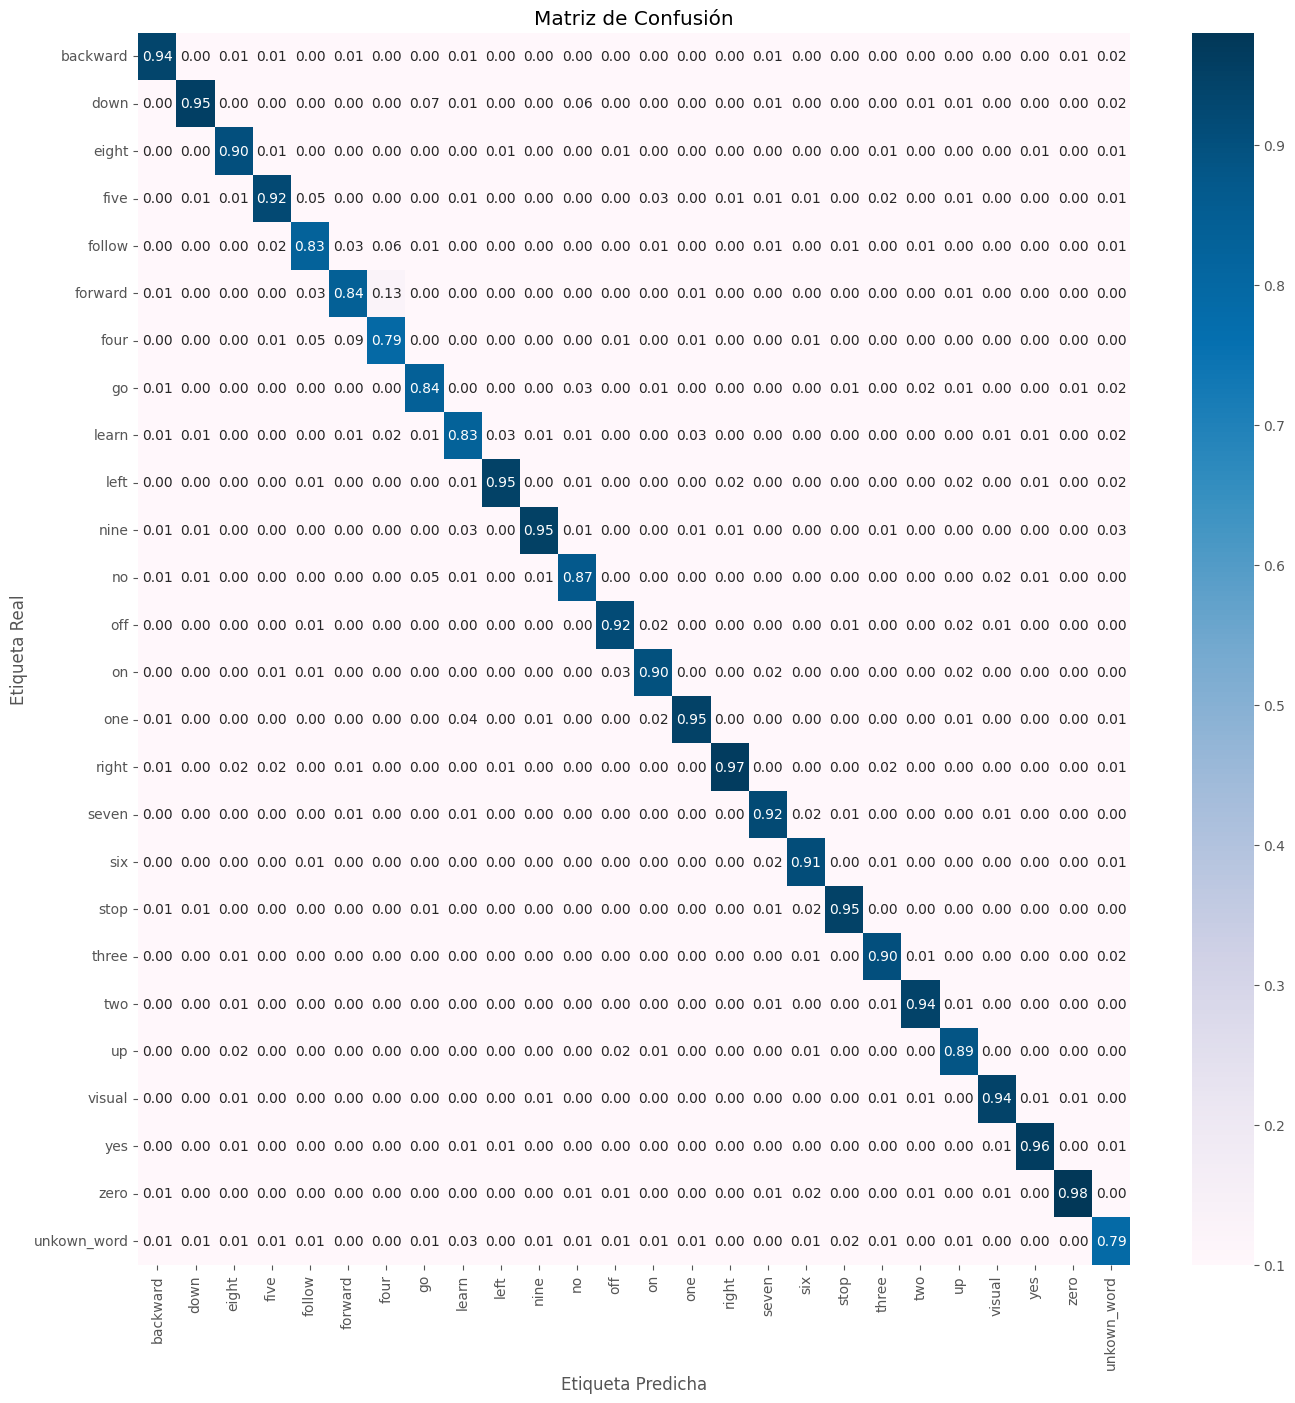

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_05, h_exp_b1_gru_lme_0_05, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_06

In [ ]:
exp_b1_gru_lme_0_06 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.4),
    GRU(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_06.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_06.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_06.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_06 = exp_b1_gru_lme_0_06.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1966 - loss: 2.6451
Epoch 1: val_loss improved from inf to 0.86673, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.1967 - loss: 2.6445 - val_accuracy: 0.7318 - val_loss: 0.8667 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7119 - loss: 0.9290
Epoch 2: val_loss improved from 0.86673 to 0.65770, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.7120 - loss: 0.9288 - val_accuracy: 0.7901 - val_loss: 0.6577 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7926 - loss: 0.6648
Epoch 3: val_loss improved from 0.65770 to 0.56691, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7926 - loss: 0.6647 - val_accuracy: 0.8324 - val_loss: 0.5669 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8260 - loss: 0.5803
Epoch 4: val_loss improved from 0.56691 to 0.48653, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8261 - loss: 0.5802 - val_accuracy: 0.8631 - val_loss: 0.4865 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8596 - loss: 0.4713
Epoch 5: val_loss improved from 0.48653 to 0.46309, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.8596 - loss: 0.4713 - val_accuracy: 0.8691 - val_loss: 0.4631 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8804 - loss: 0.4078
Epoch 6: val_loss improved from 0.46309 to 0.42804, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8804 - loss: 0.4078 - val_accuracy: 0.8817 - val_loss: 0.4280 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8936 - loss: 0.3623
Epoch 7: val_loss improved from 0.42804 to 0.41622, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_06.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8936 - loss: 0.3623 - val_accuracy: 0.8823 - val_loss: 0.4162 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9032 - loss: 0.3236
Epoch 8: val_loss did not improve from 0.41622
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9032 - loss: 0.3235 - val_accuracy: 0.8814 - val_loss: 0.4288 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9119 - loss: 0.2975
Epoch 9: val_loss did not improve from 0.41622
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.9119 - loss: 0.2975 - val_accuracy: 0.8886 - val_loss: 0.4168 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1327/1328 ━━━━━━━━━━━━━━━━━━

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9314 - loss: 0.2249 - val_accuracy: 0.9015 - val_loss: 0.4007 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9364 - loss: 0.2136
Epoch 13: val_loss did not improve from 0.40070
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9364 - loss: 0.2136 - val_accuracy: 0.8964 - val_loss: 0.4112 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9394 - loss: 0.2008
Epoch 14: val_loss did not improve from 0.40070
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9394 - loss: 0.2008 - val_accuracy: 0.9030 - val_loss: 0.4216 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1327/1328 ━━━━━━━━━━━━

In [ ]:
exp_b1_gru_lme_0_06.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                         │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_11 (GRU)                         │ (None, 63, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 26)                  │           3,354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 386,192 (1.47 MB)

 Trainable params: 128,730 (502.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 257,462 (1005.71 KB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


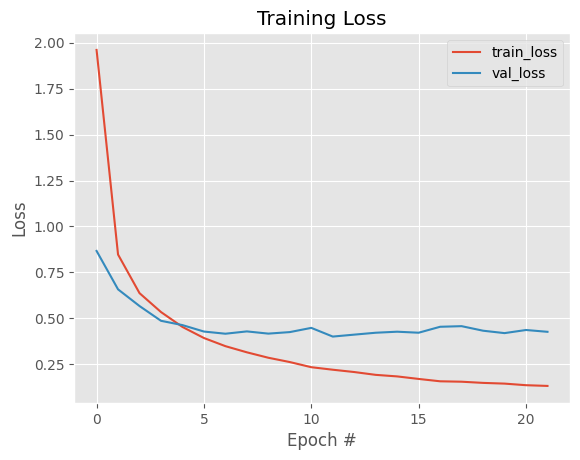

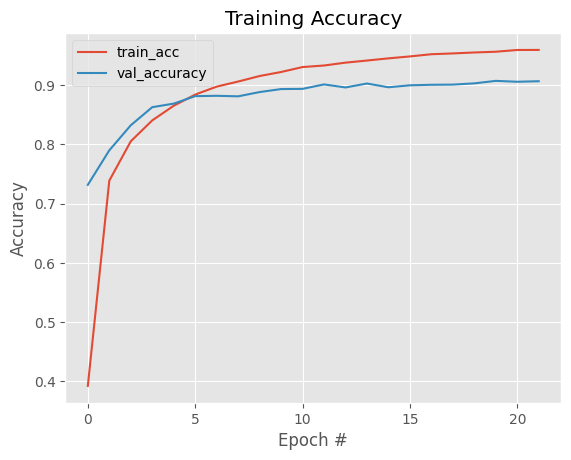

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.95      0.96      0.96       155
        down       0.93      0.90      0.91       155
       eight       0.97      0.92      0.94       155
        five       0.96      0.85      0.90       155
      follow       0.79      0.90      0.84       155
     forward       0.88      0.83      0.85       155
        four       0.87      0.82      0.84       155
          go       0.89      0.92      0.91       155
       learn       0.87      0.87      0.87       155
        left       0.94      0.95      0.95       155
        nine       0.95      0.92      0.93       155
          no       0.90      0.94      0.91       155
         off       0.94      0.93      0.93       155
          on       0.93      0.91      0.92       155
         one       0.92      0.93      0.93       155
       right       0.97      0.89      0.93       155
       seven       0.96      0.97      0.96       

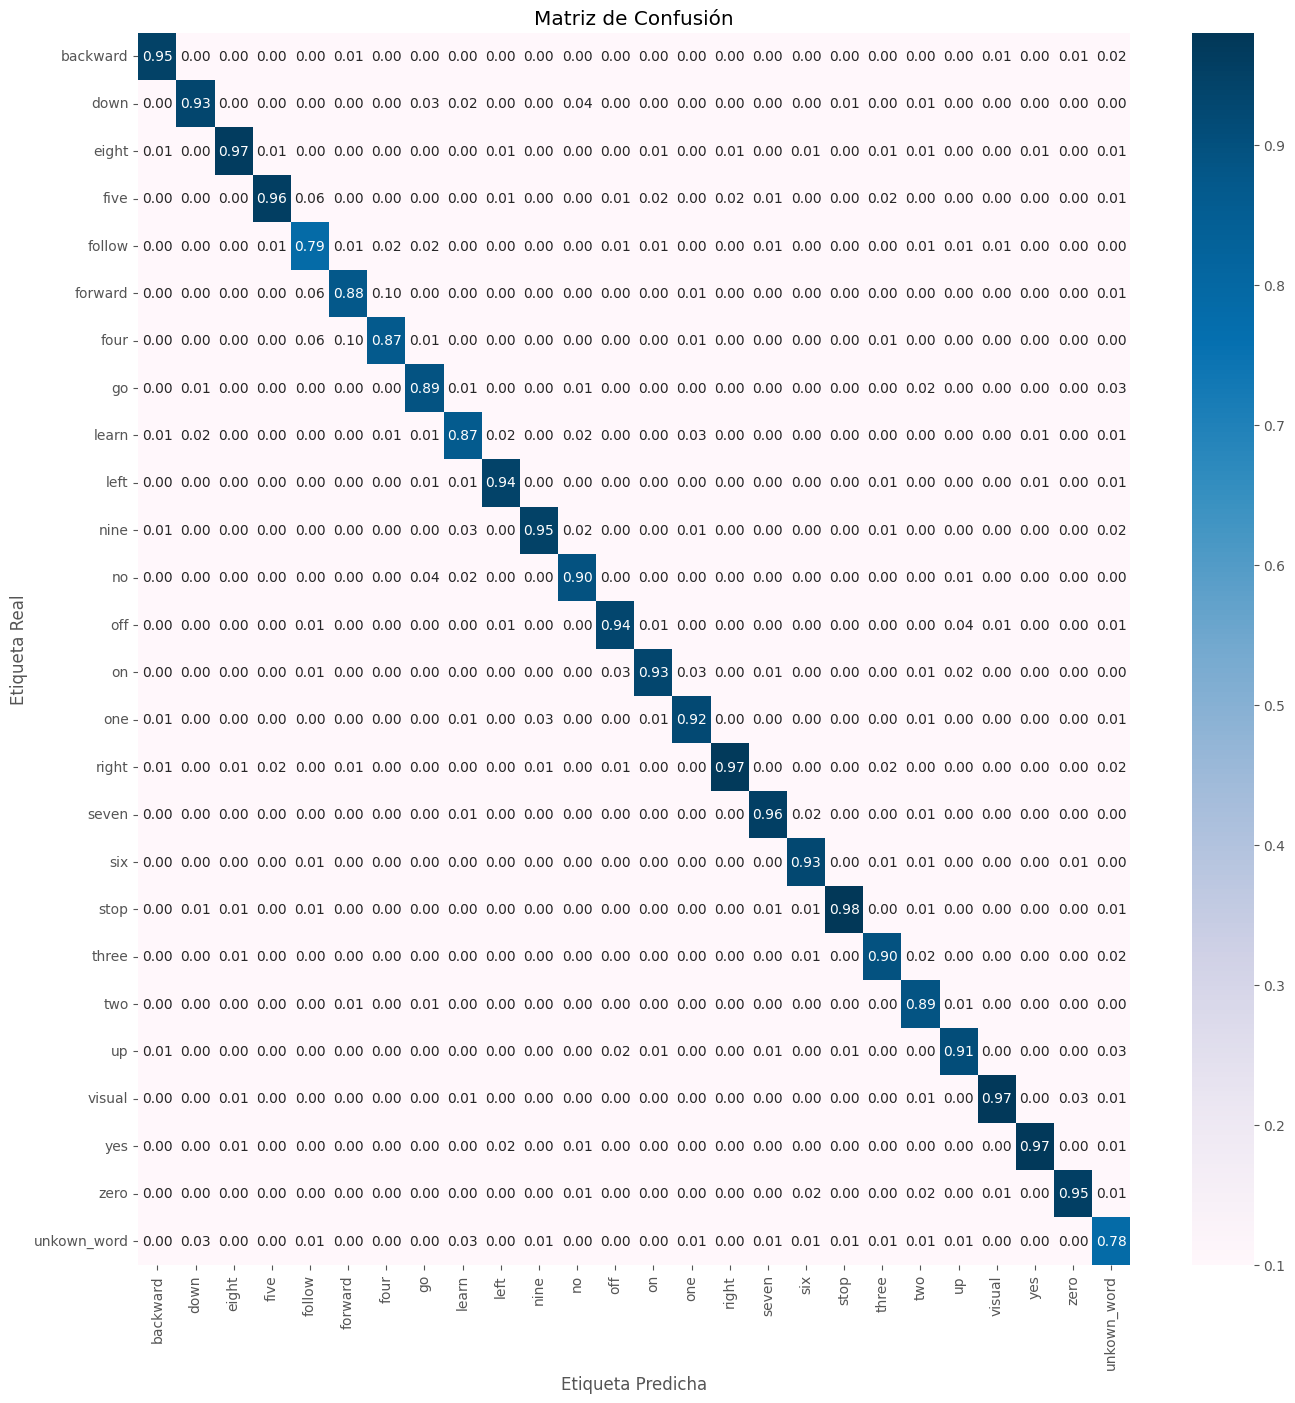

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_06, h_exp_b1_gru_lme_0_06, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_07

In [ ]:
exp_b1_gru_lme_0_07 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.4),
    GRU(64, return_sequences=True, activation='relu'),
    Dropout(0.4),
    GRU(32, return_sequences=False, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_07.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_07.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_07.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_07 = exp_b1_gru_lme_0_07.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1118 - loss: 2.9088
Epoch 1: val_loss improved from inf to 1.33796, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.1119 - loss: 2.9085 - val_accuracy: 0.5565 - val_loss: 1.3380 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5666 - loss: 1.3298
Epoch 2: val_loss improved from 1.33796 to 0.83314, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.5667 - loss: 1.3297 - val_accuracy: 0.7495 - val_loss: 0.8331 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7066 - loss: 0.9268
Epoch 3: val_loss did not improve from 0.83314
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.7066 - loss: 0.9267 - val_accuracy: 0.7465 - val_loss: 0.8502 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7314 - loss: 0.8704
Epoch 4: val_loss improved from 0.83314 to 0.62256, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.7315 - loss: 0.8702 - val_accuracy: 0.8090 - val_loss: 0.6226 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7896 - loss: 0.6805
Epoch 5: val_loss improved from 0.62256 to 0.60380, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7896 - loss: 0.6805 - val_accuracy: 0.8246 - val_loss: 0.6038 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8087 - loss: 0.6084
Epoch 6: val_loss improved from 0.60380 to 0.59521, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.8087 - loss: 0.6084 - val_accuracy: 0.8336 - val_loss: 0.5952 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8274 - loss: 0.5565
Epoch 7: val_loss improved from 0.59521 to 0.53664, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8274 - loss: 0.5565 - val_accuracy: 0.8453 - val_loss: 0.5366 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8489 - loss: 0.4997
Epoch 8: val_loss improved from 0.53664 to 0.51924, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8489 - loss: 0.4997 - val_accuracy: 0.8580 - val_loss: 0.5192 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8624 - loss: 0.4625
Epoch 9: val_loss improved from 0.51924 to 0.51262, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8624 - loss: 0.4625 - val_accuracy: 0.8658 - val_loss: 0.5126 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8745 - loss: 0.4278
Epoch 10: val_loss improved from 0.51262 to 0.50186, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8745 - loss: 0.4278 - val_accuracy: 0.8745 - val_loss: 0.5019 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8833 - loss: 0.4027
Epoch 11: val_loss did not improve from 0.50186
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.8833 - loss: 0.4027 - val_accuracy: 0.8730 - val_loss: 0.5107 - learning_rate: 3.4868e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0003138105960900001.
Epoch 12/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8941 - loss: 0.3639
Epoch 12: val_loss improved from 0.50186 to 0.49715, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - accuracy: 0.8941 - loss: 0.3639 - val_accuracy: 0.8775 - val_loss: 0.4971 - learning_rate: 3.1381e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0002824295364810001.
Epoch 13/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9007 - loss: 0.3437
Epoch 13: val_loss improved from 0.49715 to 0.47198, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_07.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.9007 - loss: 0.3437 - val_accuracy: 0.8781 - val_loss: 0.4720 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9074 - loss: 0.3169
Epoch 14: val_loss did not improve from 0.47198
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.9074 - loss: 0.3169 - val_accuracy: 0.8829 - val_loss: 0.4811 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9144 - loss: 0.2998
Epoch 15: val_loss did not improve from 0.47198
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.9144 - loss: 0.2998 - val_accuracy: 0.8865 - val_loss: 0.4931 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1327/1328 ━━━━━━━━━━━━

In [ ]:
exp_b1_gru_lme_0_07.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_13 (GRU)                         │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_14 (GRU)                         │ (None, 63, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,968 (1.55 MB)

 Trainable params: 135,322 (528.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,646 (1.03 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


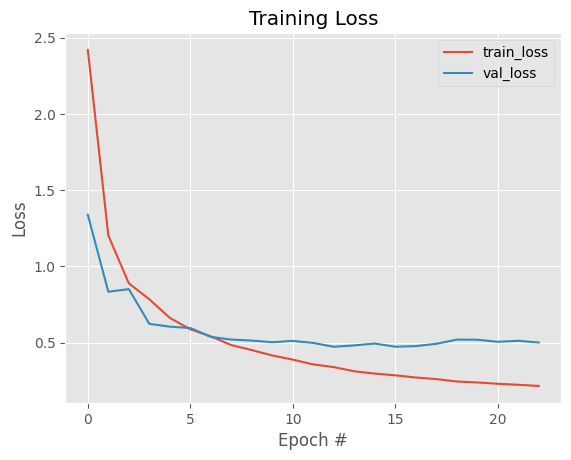

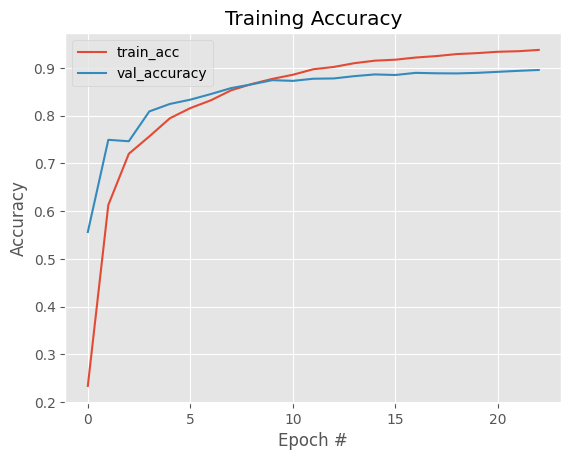

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.98      0.95      0.96       155
        down       0.96      0.87      0.91       155
       eight       0.96      0.92      0.94       155
        five       0.93      0.91      0.92       155
      follow       0.79      0.92      0.85       155
     forward       0.81      0.79      0.80       155
        four       0.80      0.75      0.78       155
          go       0.88      0.91      0.89       155
       learn       0.82      0.82      0.82       155
        left       0.92      0.90      0.91       155
        nine       0.95      0.92      0.93       155
          no       0.87      0.92      0.90       155
         off       0.95      0.95      0.95       155
          on       0.93      0.92      0.92       155
         one       0.88      0.93      0.91       155
       right       0.99      0.90      0.94       155
       seven       0.98      0.97      0.98       

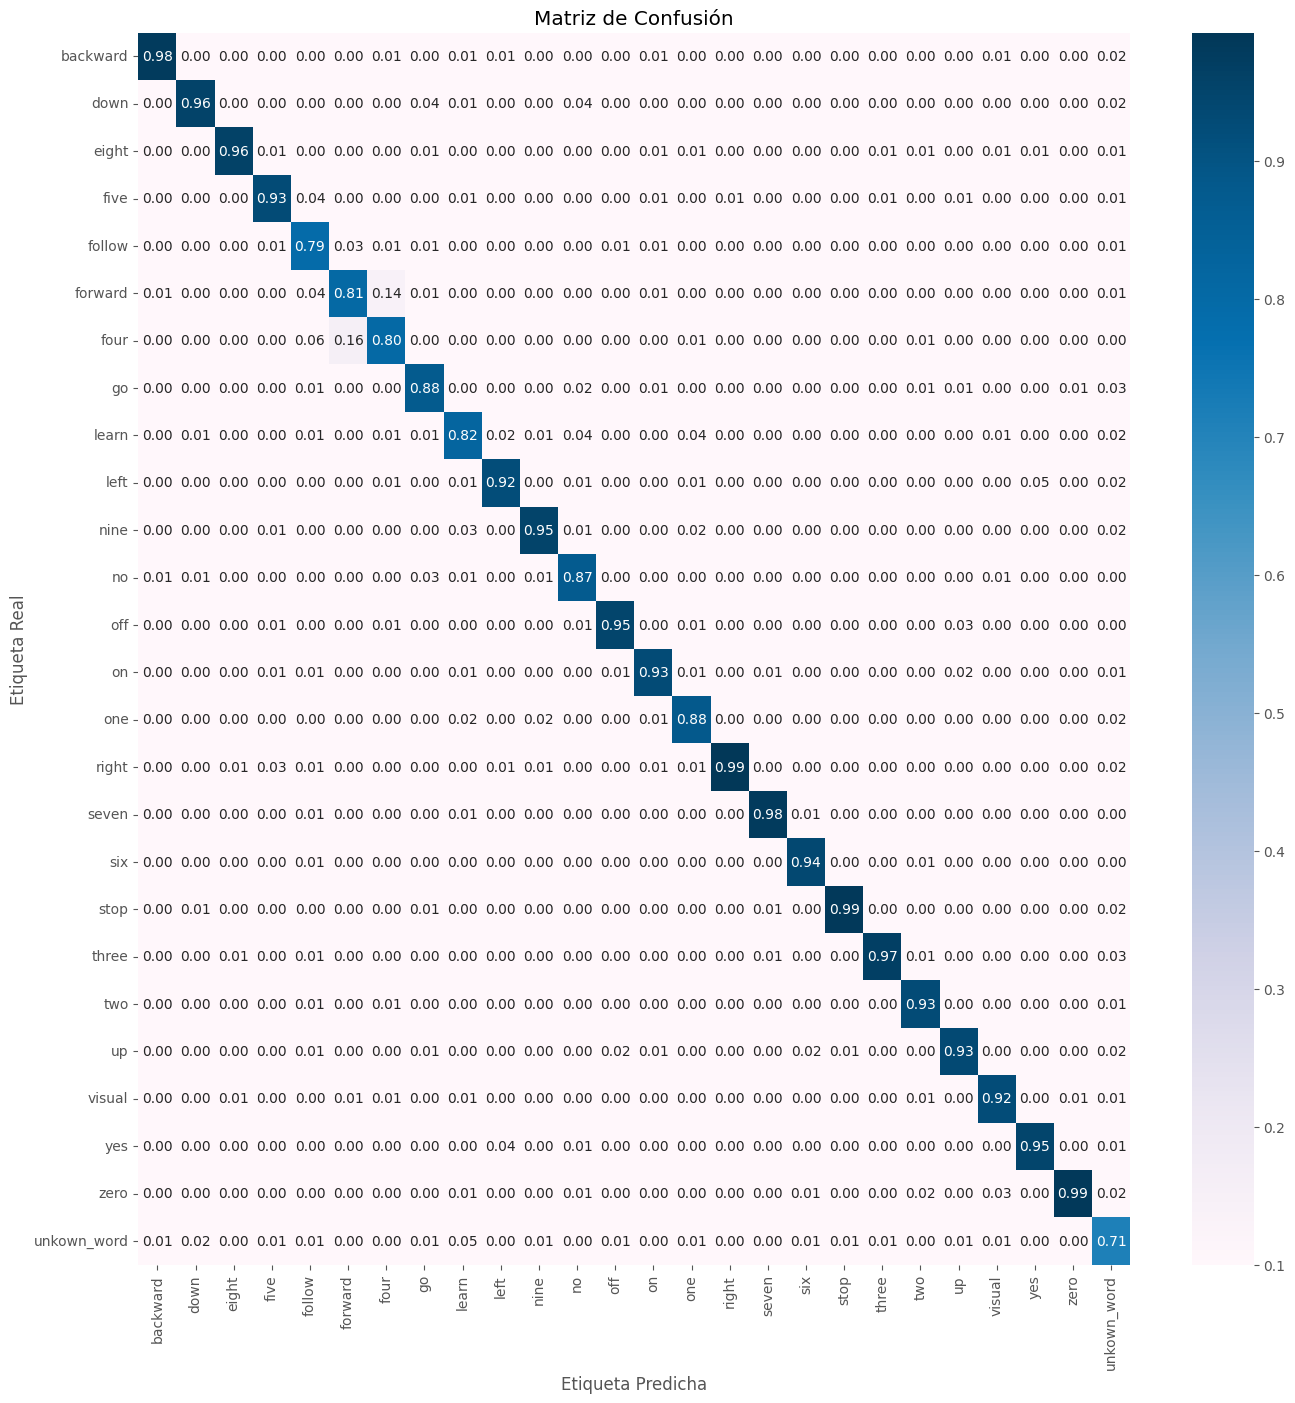

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_07, h_exp_b1_gru_lme_0_07, x_test, y_test, batch_size, classes)
mis.show_all()

### Experimento_b1_gru_lme_0_09

In [ ]:
exp_b1_gru_lme_0_09 = Sequential([
    GRU(128, return_sequences=True, input_shape=(63, 64), activation='relu'),
    Dropout(0.5),
    GRU(128, return_sequences=True, activation='relu'),
    Dropout(0.5),
    GRU(128, return_sequences=False, activation='relu'),
    Dropout(0.4),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_classes , activation='softmax')
])

exp_b1_gru_lme_0_09.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Callbacks
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)
earlystop = EarlyStopping(patience=10)
mcp = ModelCheckpoint(filepath=os.path.join(path_save_downsampled, 'models/exp_b1_gru_lme_0_09.h5'), verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(path_save_downsampled, 'log/exp_b1_gru_lme_0_09.csv'))

In [ ]:
y_train.shape

(42465, 26)

In [ ]:
# Train
batch_size = 32
h_exp_b1_gru_lme_0_09 = exp_b1_gru_lme_0_09.fit(x_train, y_train, batch_size=batch_size, epochs=90, validation_data=(x_val, y_val), callbacks=[learning_rate, earlystop, mcp, csv_logger])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1812 - loss: 2.7287
Epoch 1: val_loss improved from inf to 1.07138, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.1813 - loss: 2.7282 - val_accuracy: 0.6619 - val_loss: 1.0714 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7176 - loss: 0.9097
Epoch 2: val_loss improved from 1.07138 to 0.66592, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.7176 - loss: 0.9095 - val_accuracy: 0.7949 - val_loss: 0.6659 - learning_rate: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8036 - loss: 0.6373
Epoch 3: val_loss improved from 0.66592 to 0.51235, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8037 - loss: 0.6372 - val_accuracy: 0.8480 - val_loss: 0.5124 - learning_rate: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8470 - loss: 0.5158
Epoch 4: val_loss improved from 0.51235 to 0.46360, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8470 - loss: 0.5158 - val_accuracy: 0.8661 - val_loss: 0.4636 - learning_rate: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8719 - loss: 0.4383
Epoch 5: val_loss improved from 0.46360 to 0.45569, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.8719 - loss: 0.4383 - val_accuracy: 0.8736 - val_loss: 0.4557 - learning_rate: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8889 - loss: 0.3795
Epoch 6: val_loss improved from 0.45569 to 0.44915, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.8889 - loss: 0.3795 - val_accuracy: 0.8733 - val_loss: 0.4491 - learning_rate: 5.9049e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.000531441.
Epoch 7/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9008 - loss: 0.3444
Epoch 7: val_loss improved from 0.44915 to 0.44024, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.9008 - loss: 0.3443 - val_accuracy: 0.8781 - val_loss: 0.4402 - learning_rate: 5.3144e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0004782969000000001.
Epoch 8/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9125 - loss: 0.2992
Epoch 8: val_loss improved from 0.44024 to 0.41874, saving model to /content/gdrive/MyDrive/speech_commands_data/downsampled_dataset/models/exp_b1_gru_lme_0_09.h5


1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.9125 - loss: 0.2992 - val_accuracy: 0.8898 - val_loss: 0.4187 - learning_rate: 4.7830e-04

Epoch 9: LearningRateScheduler setting learning rate to 0.0004304672100000001.
Epoch 9/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9198 - loss: 0.2721
Epoch 9: val_loss did not improve from 0.41874
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9198 - loss: 0.2721 - val_accuracy: 0.8850 - val_loss: 0.4386 - learning_rate: 4.3047e-04

Epoch 10: LearningRateScheduler setting learning rate to 0.0003874204890000001.
Epoch 10/90
1327/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9253 - loss: 0.2587
Epoch 10: val_loss did not improve from 0.41874
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.9253 - loss: 0.2586 - val_accuracy: 0.8904 - val_loss: 0.4188 - learning_rate: 3.8742e-04

Epoch 11: LearningRateScheduler setting learning rate to 0.0003486784401000001.
Epoch 11/90
1326/1328 ━━━━━━━━━━━━━━━

1328/1328 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.9402 - loss: 0.2020 - val_accuracy: 0.8952 - val_loss: 0.4172 - learning_rate: 2.8243e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0002541865828329001.
Epoch 14/90
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9422 - loss: 0.1933
Epoch 14: val_loss did not improve from 0.41722
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9422 - loss: 0.1933 - val_accuracy: 0.9015 - val_loss: 0.4230 - learning_rate: 2.5419e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.0002287679245496101.
Epoch 15/90
1326/1328 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9466 - loss: 0.1834
Epoch 15: val_loss did not improve from 0.41722
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.9466 - loss: 0.1834 - val_accuracy: 0.8991 - val_loss: 0.4434 - learning_rate: 2.2877e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.0002058911320946491.
Epoch 16/90
1327/1328 ━━━━━━━━━━━━

In [ ]:
exp_b1_gru_lme_0_09.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                         │ (None, 63, 128)             │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_17 (GRU)                         │ (None, 63, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 63, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_18 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 847,760 (3.23 MB)

 Trainable params: 282,586 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 565,174 (2.16 MB)

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


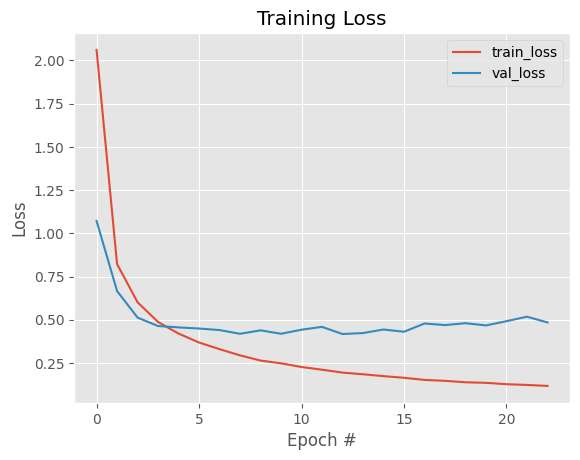

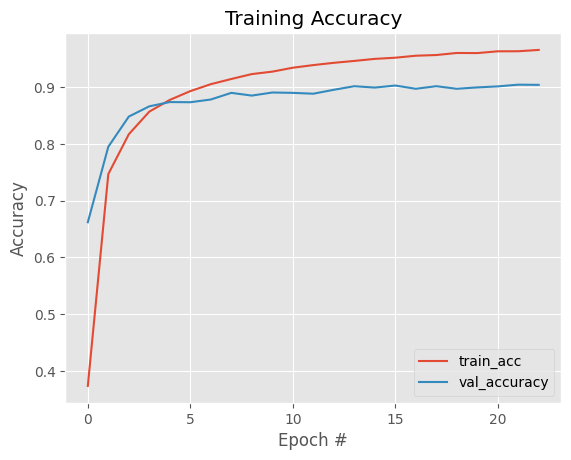

[INFO]: Evaluando el modelo...
              precision    recall  f1-score   support

    backward       0.89      0.95      0.92       155
        down       0.91      0.85      0.88       155
       eight       0.93      0.88      0.90       155
        five       0.90      0.91      0.90       155
      follow       0.81      0.89      0.85       155
     forward       0.82      0.88      0.85       155
        four       0.81      0.77      0.79       155
          go       0.89      0.87      0.88       155
       learn       0.91      0.74      0.81       155
        left       0.96      0.93      0.94       155
        nine       0.94      0.94      0.94       155
          no       0.81      0.92      0.86       155
         off       0.97      0.95      0.96       155
          on       0.94      0.93      0.94       155
         one       0.94      0.95      0.94       155
       right       0.99      0.89      0.94       155
       seven       0.92      0.98      0.95       

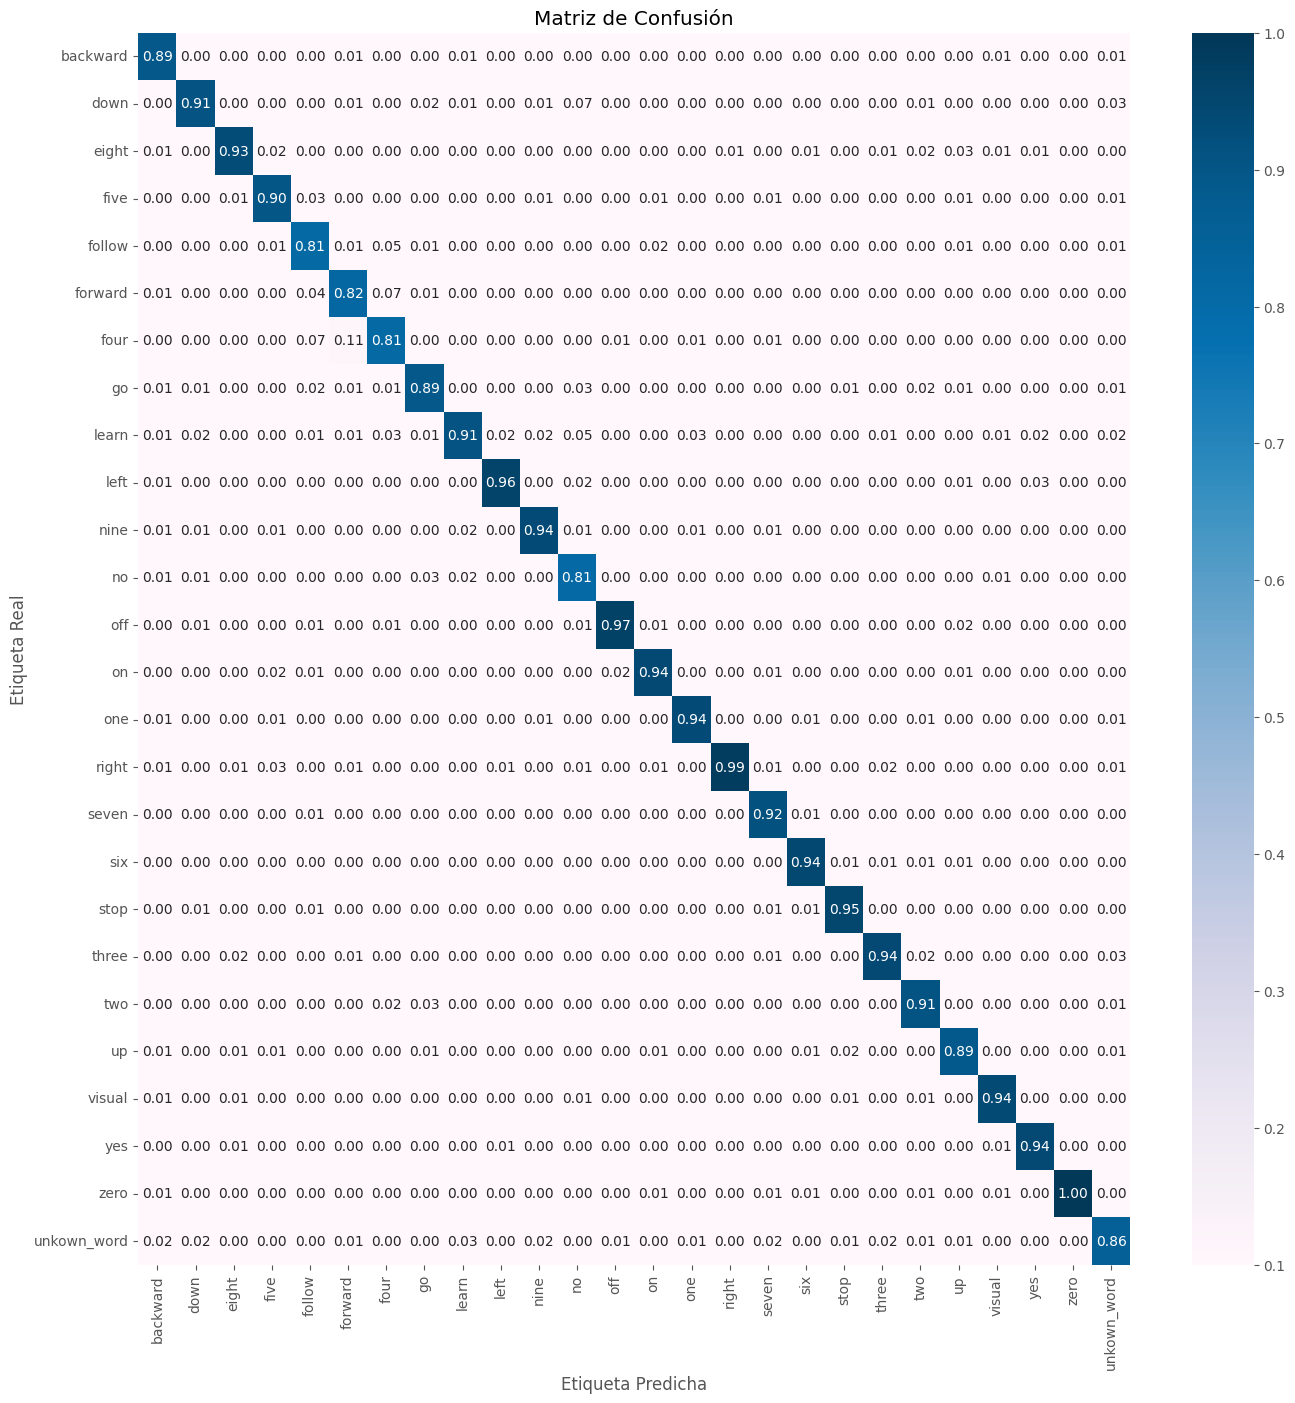

In [ ]:
mis = MetricsInfoShower(exp_b1_gru_lme_0_09, h_exp_b1_gru_lme_0_09, x_test, y_test, batch_size, classes)
mis.show_all()